In [1]:
#----------------------------Import-----------------------------------
import numpy as np
import pandas as pd
import os
import glob
import importlib
import matplotlib.pyplot as plt
import sympy as sp

In [2]:

#-------------------------------------------------------------
def import_and_combine_data(folder_path):
    """
    This function reads CSV files from the specified folder, adds 'round' and 'device' columns
    based on the file names, and returns a single combined DataFrame with numeric 'round' and 'device' columns.

    Parameters:
    - folder_path: The path to the folder containing the CSV files.

    Returns:
    - A single DataFrame containing all the data from the CSV files, with numeric 'round' and 'device' columns.
    """
    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # List to hold all DataFrames
    all_dataframes = []

    # Loop through the list of CSV files and read them into DataFrames
    for file in csv_files:
        # Extract the filename (without the directory path) and remove the extension
        filename = os.path.basename(file).replace('.csv', '')

        # Extract 'round' and 'device' from the filename (e.g., 'features_r4-d01.csv')
        round_key = filename.replace('features_', '').split('-')[0]  # Extracts 'r4'
        device_key = filename.split('-')[1]  # Extracts 'd01', 'd02', etc.

        try:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file)

            # If the DataFrame is empty, skip it
            if df.empty:
                print(f"Warning: {file} is empty and will be skipped.")
                continue

            # Convert 'round' from 'r4' to 4, 'device' from 'd01' to 1
            round_number = int(round_key[1:])  # Extract the numeric part after 'r'
            device_number = int(device_key[1:])  # Extract the numeric part after 'd'

            # Add the 'round' and 'device' columns to the DataFrame
            df['round'] = round_number
            df['device'] = device_number

            # Append the modified DataFrame to the list
            all_dataframes.append(df)

        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue

    # Check if any valid DataFrames were added
    if not all_dataframes:
        raise ValueError("No valid DataFrames to concatenate.")

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(all_dataframes, ignore_index=True)

    return final_df


def plot_a_round(df, round_number):
    """
    Create subplots with a title, legend, and adjustable spacing between the title and the subplots
    for a specific round from a single DataFrame that includes 'round' and 'device' as numeric columns.
    
    Parameters:
    - df: The single DataFrame containing all the data.
    - round_number: The round identifier (e.g., 4 for 'r4') or '0' to plot all rounds.
    """

    # If round_number is 'all', iterate through all rounds
    if round_number == 0:
        for group_key in df['round'].unique():
            plot_a_round(df, group_key)  # Recursively call the function for each round
        return  # Exit after plotting all rounds

    # Filter the DataFrame for the specific round
    round_data = df[df['round'] == round_number]

    # List of devices in the selected round
    devices = round_data['device'].unique()

    # Extract unique and common features from the first device's data
    # Assuming the column structure is the same for all devices in a round
    unique_features = round_data.columns[1:8].tolist()  # Modify indices as needed for your actual column structure
    common_features = round_data.columns[8:17].tolist()

    nbr_devices = len(devices)
    total_features = len(unique_features) + len(common_features)

    # Determine grid size (let's keep 4 columns for consistency)
    nrows = (total_features + 3) // 4  # Dynamically adjust rows to fit all features

    # Create subplots
    fig, ax = plt.subplots(nrows, 4, figsize=(30, 5 * nrows))  # Dynamic row count, 4 columns
    ax = ax.flatten()

    # Set title dynamically based on the numeric round_number
    fig.suptitle(f'Round {round_number}', fontsize=40)

    # List to hold the line objects and labels for the legend
    lines = []
    labels = []

    # Device labels (for legend), since device is now numeric
    device_labels = [f'Device {device}' for device in devices]
    device_labels.append('Shared data')

    # Plot unique features for each device
    for feature_idx, feature in enumerate(unique_features):
        for device_idx, device in enumerate(devices):
            device_data = round_data[round_data['device'] == device]  # Filter data for the specific device
            if device_idx == 0:
                line = device_data.plot(x='cycle', y=feature, kind='line', ax=ax[feature_idx], title=f'{feature} vs. Cycle', legend=False)
            else:
                line = device_data.plot(x='cycle', y=feature, kind='line', ax=ax[feature_idx], legend=False)

            if feature_idx == 0:
                lines.append(line.get_lines()[device_idx])  # Collect the first line object from each device
                labels.append(device_labels[device_idx])  # Add the corresponding label (Device 1, Device 2, etc.)

    # Plot common features from the first device's data (assuming shared data is the same across devices)
    for feature_idx, feature in enumerate(common_features):
        # Compute the index in the flattened ax array for the common features
        index_in_ax = feature_idx + len(unique_features)
        line = round_data[round_data['device'] == devices[0]].plot(x='cycle', y=feature, kind='line', ax=ax[index_in_ax], title=f'{feature} vs. Cycle', legend=False, color='black')
        if feature_idx == 0:
            lines.append(line.get_lines()[0])
            labels.append(device_labels[-1])  # Add label for shared data

    plt.tight_layout(rect=[0, 0, 1, 0.90])

    # Adjust layout and add a legend
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.1, 0.95), ncol=min(3, nbr_devices + 1), fontsize=18)

    plt.show()


def find_cycle_at_full_consumption(df, round_column='round', device_column='device', 
                                 cycle_column='cycle', consumed_life_column='consumed_life'):
    # Group the data by round and device
    grouped = df.groupby([round_column, device_column])
    
    # Define inner function to find first cycle at full consumption
    def find_first_full_cycle(group):
        # Find all rows where consumed_life >= 1
        full_consumption = group[group[consumed_life_column] >= 1]
        
        # If we found any rows, return the first cycle number
        if not full_consumption.empty:
            return full_consumption[cycle_column].iloc[0]
        else:
            return np.nan
    
    # Apply the function to each group and reset the index
    results = grouped.apply(find_first_full_cycle).reset_index()
    results.columns = [round_column, device_column, 'cycle_at_full_consumption']
    
    return results


In [3]:
#----------------------------load_data delete ()-----------------------------------
folder_path = 'C:\\Users\\Master_Student\\ml\\Data\\data_oct_2023\\features\\'
df = import_and_combine_data(folder_path)
# Delete all parentheses in column names, this for PySRRegressor to work
df.columns = df.columns.str.replace(r'\(.*?\)', '', regex=True).str.strip()
print(df.columns)

Index(['cycle', 'consumed_life', 'end_voltage', 'end_resistance',
       'end_resistance_residual', 'end_resistance_residual_cleaned',
       'min_temperature', 'max_temperature', 'min_block_temperature_1',
       'max_block_temperature_1', 'min_block_temperature_2',
       'max_block_temperature_2', 'avg_max_block_temperature',
       'min_water_inlet_temperature', 'max_water_inlet_temperature',
       'min_water_outlet_temperature', 'max_water_outlet_temperature', 'round',
       'device'],
      dtype='object')


In [4]:
#---------------------------Fix Missing data-------------------------------------------
def fix_missing_data(group):
    # Interpolate
    group = group.interpolate(method='linear')
    # Forward fill
    group = group.ffill()
    # Backward fill
    group = group.bfill()
    return group

# Apply all operations in a single pass
grouped = df.groupby(['round', 'device'], group_keys=False)
df = grouped.apply(fix_missing_data)

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\2503624821.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(fix_missing_data)


In [5]:
df['swing_temperature'] = df['max_temperature'] - df['min_temperature'] 


In [6]:
columns_to_clean = ['end_voltage', 'end_resistance',
       'end_resistance_residual', 'end_resistance_residual_cleaned',
       'min_temperature', 'max_temperature', 'min_block_temperature_1',
       'max_block_temperature_1', 'min_block_temperature_2',
       'max_block_temperature_2', 'avg_max_block_temperature',
       'min_water_inlet_temperature', 'max_water_inlet_temperature',
       'min_water_outlet_temperature', 'max_water_outlet_temperature', 'swing_temperature'] # tar bort cycle!

In [7]:
#-----------------------------Abbrevations for plotting---------------------------------------------
# Create the abbreviation dictionary for renaming the columns
abbreviations = {
    'cycle': 'Cyc',
    'consumed_life': 'CL',
    'end_voltage': 'V_end',
    'end_resistance': 'R_end',
    'end_resistance_residual': 'R_res',
    'end_resistance_residual_cleaned': 'R_res_cl',
    'min_temperature': 'T_min',
    'max_temperature': 'T_max',
    'min_block_temperature_1': 'T_B1_min',
    'max_block_temperature_1': 'T_B1_max',
    'min_block_temperature_2': 'T_B2_min',
    'max_block_temperature_2': 'T_B2_max',
    'avg_max_block_temperature': 'T_B_avg_max',
    'min_water_inlet_temperature': 'T_WI_min',
    'max_water_inlet_temperature': 'T_WI_max',
    'min_water_outlet_temperature': 'T_WO_min',
    'max_water_outlet_temperature': 'T_WO_max',
    'swing_temperature': 'T_Sw'
} 

# Function to replace column names with abbreviations
def get_abbreviation(column_name):
    return abbreviations.get(column_name, column_name)  # Use the abbreviation if it exists, otherwise use the original name

In [8]:
def get_Cycle_thresholds(df, devices, rounds, min_temp_threshold=40):
    """
    Computes cycles and minimum temperatures for each device and round.

    Parameters:
    - df: DataFrame containing the data
    - devices: List of device identifiers or single device to process
    - rounds: List of round numbers or single round to process
    - min_temp_threshold: Minimum temperature threshold

    Returns:
    - Dictionary with device IDs mapping to tuple of (cycles at minimums, minimum temperatures)
    """
    round_data = {}

    for round_number in rounds:
        device_data = {}
        
        for device in devices:
            exceed_threshold_df = df[(df['device'] == device) & 
                                   (df['round'] == round_number) & 
                                   (df['min_temperature'] <= min_temp_threshold)]
            
            if exceed_threshold_df.empty:
                device_data[device] = ([], [])
                continue
            
            exceed_threshold_df = exceed_threshold_df.reset_index(drop=True)
            exceed_threshold_df['segment'] = (exceed_threshold_df['cycle'].diff() > 1).cumsum()
            
            segments = exceed_threshold_df.groupby('segment')
            min_temp_indices = segments['min_temperature'].idxmin()
            
            cycles = exceed_threshold_df.loc[min_temp_indices, 'cycle'].astype(float).tolist()
            temps = exceed_threshold_df.loc[min_temp_indices, 'min_temperature'].astype(float).tolist()
            
            device_data[device] = (cycles, temps)
        
        round_data[round_number] = device_data
    
    return round_data[rounds[0]] if len(rounds) == 1 else round_data

# Example usage
#thresholds_single_round = get_Cycle_thresholds(
    #df=df,
    #devices=[4],
    #rounds=[8],
    #min_temp_threshold=40
#)

#print(thresholds_single_round)

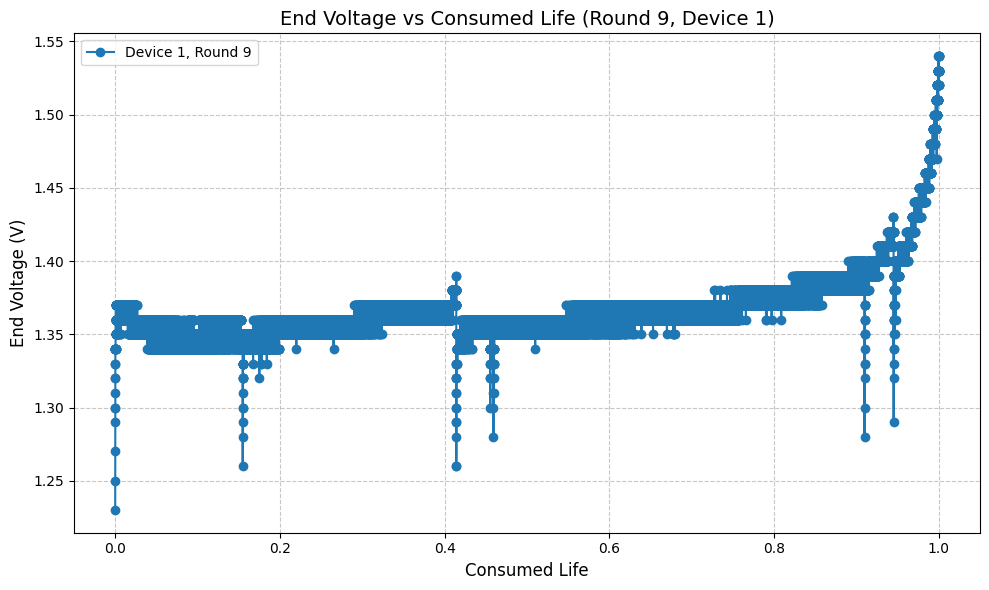

In [9]:
import matplotlib.pyplot as plt

# Normalize 'consumed_life' for device 1 in round 9 where 'consumed_life' <= 0.988
# Delete rows where 'consumed_life' > 0.988 for device 1 in round 9
df = df[~((df['round'] == 9) & (df['device'] == 1) & (df['consumed_life'] > 0.985))]
# Filter data for device 1 in round 9
condition = (df['round'] == 9) & (df['device'] == 1)

# Calculate the new 'consumed_life' as the normalized 'cycle' for the remaining rows
df.loc[condition, 'consumed_life'] = (
    df.loc[condition, 'cycle'] / df.loc[condition, 'cycle'].max()
    
)

#-----------------------------------------------------------plot-----------------------------------------------------
# Filter the data for round 9 and device 1
filtered_data = df[(df['round'] == 9) & (df['device'] == 1)]

# Plot end_voltage vs consumed_life
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['consumed_life'], filtered_data['end_voltage'], marker='o', linestyle='-', label='Device 1, Round 9')

# Customize the plot
plt.title('End Voltage vs Consumed Life (Round 9, Device 1)', fontsize=14)
plt.xlabel('Consumed Life', fontsize=12)
plt.ylabel('End Voltage (V)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [10]:
def make_segments(df, devices, rounds, min_temp_threshold=40, cut_at_CL_one=True, cycle_threshold=500):
    """
    Segments device data based on cycles.
    
    Parameters:
    - df: DataFrame containing the data
    - devices: List of device identifiers or single device
    - rounds: List of round numbers or single round
    - min_temp_threshold: Minimum temperature threshold
    - cut_at_CL_one: Whether to cut data at consumed life = 1
    - cycle_threshold: Minimum cycle number to include
    
    Returns:
    - Nested dictionary: round -> device -> list of DataFrames (segments)
    """
    relevant_data = df[df['round'].isin(rounds) & df['device'].isin(devices)]
    initial_rows = len(relevant_data)

    thresholds_data = get_Cycle_thresholds(relevant_data, devices, rounds, min_temp_threshold)
    
    if isinstance(devices, int):
        devices = [devices]
    if isinstance(rounds, int):
        rounds = [rounds]
        
    segmented_data = {}
    rows_removed_due_to_CL = 0
    rows_removed_due_to_cycle_threshold = 0

    for round_number in rounds:
        device_segments = {}
        
        round_thresholds = thresholds_data[round_number] if isinstance(thresholds_data, dict) else thresholds_data
        
        for device in devices:
            cycles, temps = round_thresholds.get(device, ([], []))
            
            device_data = relevant_data[(relevant_data['device'] == device) & 
                                      (relevant_data['round'] == round_number)]
            
            if cut_at_CL_one:
                before_cl_cut = len(device_data)
                device_data = device_data[device_data['consumed_life'] <= 1]
                rows_removed_due_to_CL += (before_cl_cut - len(device_data))
            
            before_cycle_cut = len(device_data)
            device_data = device_data[device_data['cycle'] >= cycle_threshold]
            rows_removed_due_to_cycle_threshold += (before_cycle_cut - len(device_data))
            
            segments = []
            if not cycles:
                segments.append(device_data)
            else:
                # First segment
                first_segment = device_data[device_data['cycle'] < cycles[0]]
                if not first_segment.empty:
                    segments.append(first_segment)
                
                # Middle segments
                for i in range(len(cycles) - 1):
                    segment = device_data[
                        (device_data['cycle'] >= cycles[i]) & 
                        (device_data['cycle'] < cycles[i + 1])
                    ]
                    if not segment.empty:
                        segments.append(segment)
                
                # Last segment
                last_segment = device_data[device_data['cycle'] >= cycles[-1]]
                if not last_segment.empty:
                    segments.append(last_segment)
            
            device_segments[device] = segments
        
        segmented_data[round_number] = device_segments
    
    remaining_rows = sum(len(seg) for round_data in segmented_data.values()
                         for device_segments in round_data.values() for seg in device_segments)
    
    removed_rows = initial_rows - remaining_rows
    print(f"segment_devices_data: Total rows removed: {removed_rows} out of {initial_rows} ({100 * removed_rows / initial_rows:.2f}%)")
    print(f"Rows removed due to consumed_life > 1: {rows_removed_due_to_CL}")
    print(f"Rows removed due to cycle < {cycle_threshold}: {rows_removed_due_to_cycle_threshold}")

    return segmented_data[rounds[0]] if len(rounds) == 1 else segmented_data

devices = list(range(1, 11)) # alltid till 11
rounds = [8, 9]
segmented_data = make_segments(
    df=df,
    devices=devices,
    rounds=rounds,
    cut_at_CL_one=True,       # Remove rows with consumed_life > 1      # Minimum segment size to keep
    cycle_threshold=2000       # Remove rows with cycle < 500
)

segment_devices_data: Total rows removed: 66231 out of 1053366 (6.29%)
Rows removed due to consumed_life > 1: 26251
Rows removed due to cycle < 2000: 39980


In [11]:
# bra!
def count_nans(segmented_data):
    total_nans = 0
    total_values = 0
    
    for round_number, devices in segmented_data.items():
        for device, segments in devices.items():
            for segment in segments:
                total_nans += segment.isna().sum().sum()
                total_values += segment.size
    
    percentage = (total_nans / total_values * 100) if total_values > 0 else 0
    print(f"Total NaN values: {total_nans:,} out of {total_values:,} values ({percentage:.2f}%)")
    
    return total_nans, total_values

# Usage
nans, values = count_nans(segmented_data)

Total NaN values: 0 out of 19,742,700 values (0.00%)


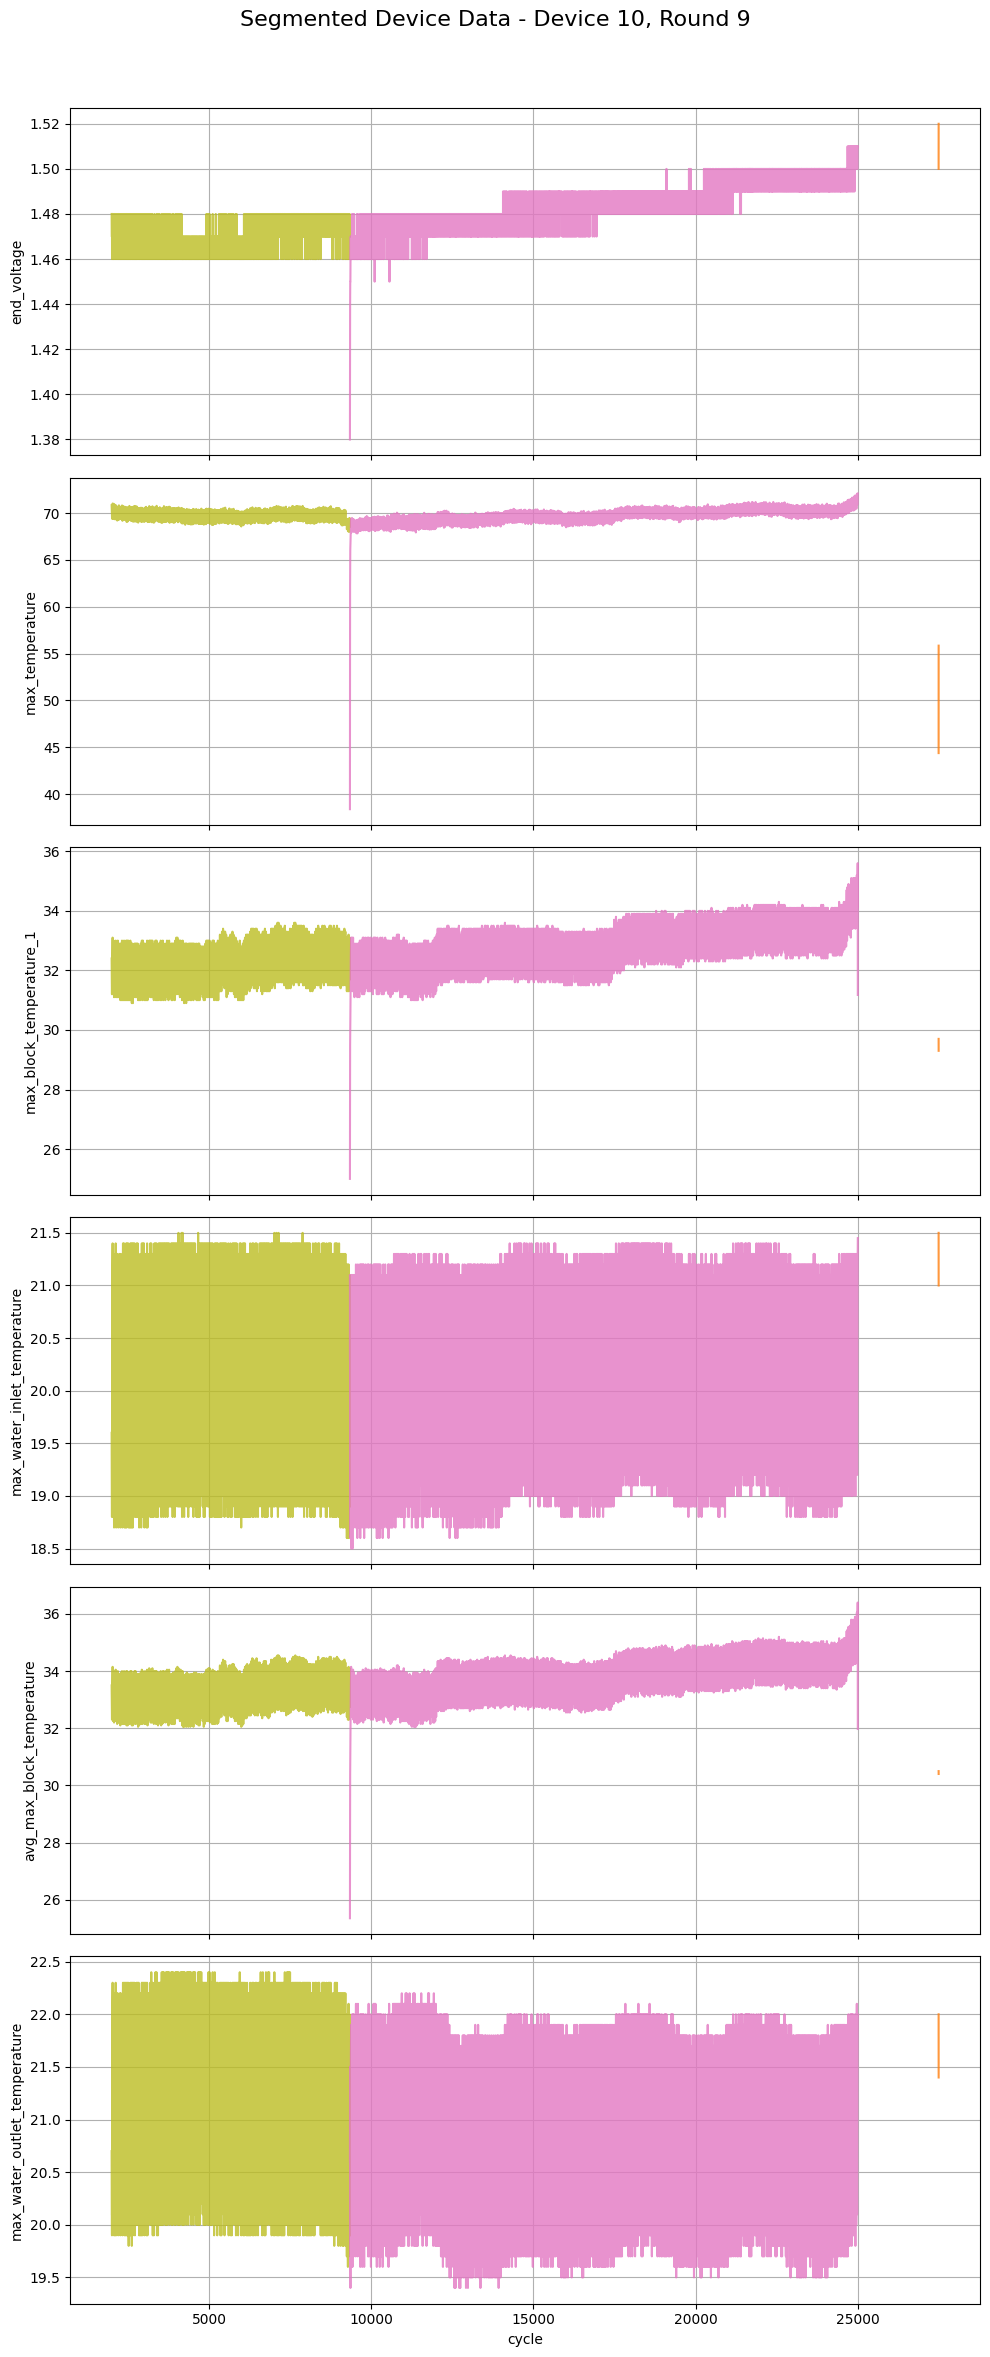

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

def plot_segmented_data(segmented_data, devices=None, rounds=None, x_column='cycle', y_columns=None, title_prefix="Segmented Data"):
    """
    Plots the segmented data with each y_column in its own subplot, with the same color scheme across all plots.
    
    Parameters:
    - segmented_data: dict
        The segmented data organized as {round: {device: [segments (DataFrames)]}}.
    - devices: list, optional
        List of devices to include in the plot. If None, plots all devices.
    - rounds: list, optional
        List of rounds to include in the plot. If None, plots all rounds.
    - x_column: str
        The column to use for the x-axis. Default is 'cycle'.
    - y_columns: list
        The columns to plot on the y-axis. Each will have its own subplot.
    - title_prefix: str
        Title prefix for the figure. The round and device will be appended.
    """
    # Define a consistent colormap for unique colors
    colors = list(mcolors.TABLEAU_COLORS.values())
    random.shuffle(colors)  # Shuffle colors for variety

    # Filter rounds and devices
    rounds_to_plot = rounds if rounds is not None else segmented_data.keys()
    
    for round_number in rounds_to_plot:
        if round_number not in segmented_data:
            continue  # Skip if the round is not in the data

        devices_to_plot = devices if devices is not None else segmented_data[round_number].keys()
        
        for device in devices_to_plot:
            if device not in segmented_data[round_number]:
                continue  # Skip if the device is not in the round

            segments = segmented_data[round_number][device]

            # Set up subplots for each y_column
            num_y_columns = len(y_columns)
            fig, axes = plt.subplots(num_y_columns, 1, figsize=(10, 4 * num_y_columns), sharex=True)
            if num_y_columns == 1:
                axes = [axes]  # Ensure axes is iterable when there's only one subplot
            
            for i, y_col in enumerate(y_columns):
                ax = axes[i]
                for j, segment in enumerate(segments):
                    if segment.empty:
                        continue
                    # Plot each segment with a unique color
                    ax.plot(segment[x_column], segment[y_col], color=colors[j % len(colors)], alpha=0.8)
                
                ax.set_ylabel(y_col)
                ax.grid(True)
            
            # Add common x-axis label and title
            axes[-1].set_xlabel(x_column)
            fig.suptitle(f"{title_prefix} - Device {device}, Round {round_number}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
            plt.show()




plot_segmented_data(
    segmented_data=segmented_data,
    devices=[10],  # Specify the devices you want to plot
    rounds=[9],  # Specify the rounds you want to plot
    x_column='cycle',  # X-axis column
    y_columns=['end_voltage', 'max_temperature', 'max_block_temperature_1', 
               'max_water_inlet_temperature', 'avg_max_block_temperature', 'max_water_outlet_temperature'],  # Example y-axis columns
    title_prefix="Segmented Device Data"
)


In [13]:
def exclude_transition_cycles(
    segmented_data, 
    transition_margin=10, 
    filter_columns=None,
    verbose=True
):
    """
    Marks data points near segment transitions as NaN based on a margin.
    Skips marking rows at the start of the first segment and the end of the last segment.
    
    Parameters:
    ----------- 
    segmented_data : dict
        Segmented data by round and device.
        Structure: {round_number: {device: [DataFrames (segments)]}}.
    transition_margin : int, optional
        Number of cycles to mark as NaN at the start and end of each segment to avoid transition regions.
    filter_columns : list, optional
        List of columns to mark as NaN based on the cycle. If None, all columns are marked as NaN (default behavior).
    verbose : bool, optional
        If True, prints the global summary. Default is True.
        
    Returns:
    --------
    filtered_segmented_data : dict
        The same structure as segmented_data, but with values near transition margins replaced with NaN,
        applied only to specified columns.
    """
    # Initialize the output dictionary with the same structure as the input
    filtered_segmented_data = {}
    total_rows_marked_nan = 0
    total_nans_marked = 0
    total_original_rows = 0

    for round_number, devices in segmented_data.items():
        for device, segments in devices.items():
            filtered_segments = []
            for i, segment in enumerate(segments):
                # Work on a copy of the DataFrame to avoid modifying the original data
                filtered_segment = segment.copy()
                original_row_count = len(segment)
                total_original_rows += original_row_count

                # Determine the range of cycles to mark as NaN
                min_cycle = filtered_segment['cycle'].min()
                max_cycle = filtered_segment['cycle'].max()

                # Adjust transition margin for boundary segments
                if i == 0:  # First segment, skip margin at the start
                    adjusted_min_cycle = min_cycle
                else:
                    adjusted_min_cycle = min_cycle + transition_margin

                if i == len(segments) - 1:  # Last segment, skip margin at the end
                    adjusted_max_cycle = max_cycle
                else:
                    adjusted_max_cycle = max_cycle - transition_margin

                rows_to_nan = ~filtered_segment['cycle'].between(adjusted_min_cycle, adjusted_max_cycle)

                # Apply NaN to the specified columns or all columns
                if filter_columns:
                    for col in filter_columns:
                        if filtered_segment[col].dtype != 'float':
                            filtered_segment[col] = filtered_segment[col].astype(float)
                    filtered_segment.loc[rows_to_nan, filter_columns] = np.nan
                else:
                    # Apply NaN to all columns
                    for col in filtered_segment.columns:
                        if col != 'cycle' and filtered_segment[col].dtype != 'float':
                            filtered_segment[col] = filtered_segment[col].astype(float)
                    filtered_segment.loc[rows_to_nan, :] = np.nan

                # Count rows and NaNs marked
                total_rows_marked_nan += rows_to_nan.sum()
                if filter_columns:
                    total_nans_marked += filtered_segment.loc[rows_to_nan, filter_columns].isna().sum().sum()
                else:
                    total_nans_marked += filtered_segment.loc[rows_to_nan, :].isna().sum().sum()

                filtered_segments.append(filtered_segment)

            filtered_segmented_data.setdefault(round_number, {})[device] = filtered_segments

    # Global summary
    if verbose and total_original_rows > 0:
        overall_percentage_nan = (total_rows_marked_nan / total_original_rows) * 100
        print(f"Total rows marked as NaN: {total_rows_marked_nan} out of {total_original_rows} ({overall_percentage_nan:.2f}%)")
        print(f"Total individual NaN values marked: {total_nans_marked}")

    return filtered_segmented_data

# Example usage
filtered_data = exclude_transition_cycles(
    segmented_data=segmented_data, 
    transition_margin=100,  # Standard transition margin 75 förr
    filter_columns=columns_to_clean,
    verbose=True
)


Total rows marked as NaN: 24227 out of 987135 (2.45%)
Total individual NaN values marked: 387632


In [14]:
nans, values = count_nans(filtered_data)

Total NaN values: 387,632 out of 19,742,700 values (1.96%)


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\3775536499.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 0.93])


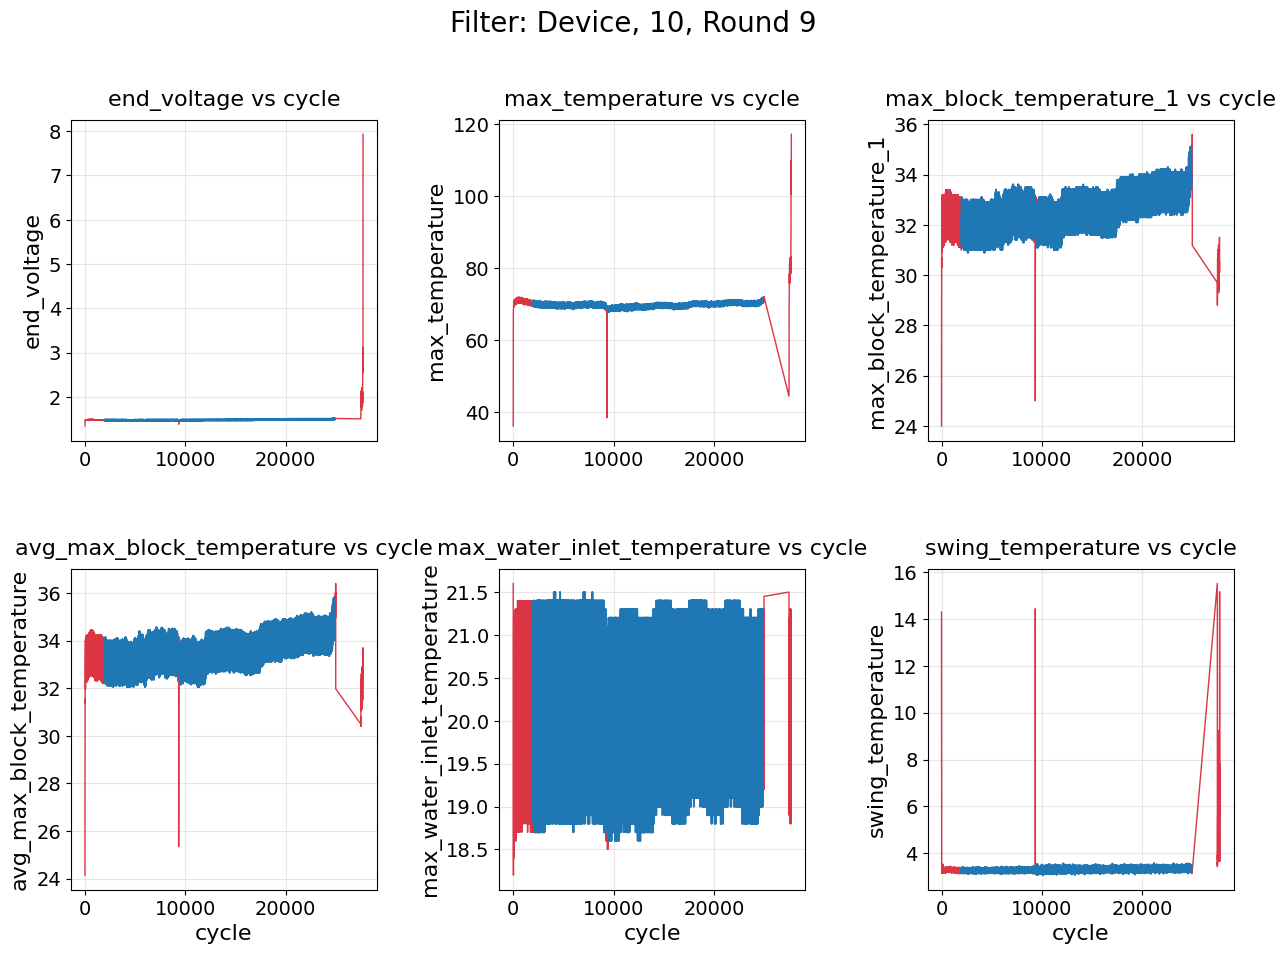

In [15]:
def plot_filter(
        filtered_data, df, devices, rounds, columns_to_plot):
    """
    Plots both filtered and unfiltered segments in a publication-ready 2x3 grid
    with increased font sizes for each device and round.
    
    The function displays the plots and does not return anything.

    Parameters:
    - filtered_data: Segmented dictionary of filtered data.
    - df: Original DataFrame containing unfiltered data.
    - devices: List of devices to process.
    - rounds: List of rounds to process.
    - columns_to_plot: List of columns to include in the plot.
    """
    # Define colors and font sizes
    filtered_color = '#1f77b4'    # Nice blue color
    unfiltered_color = '#dc3545'  # Red color for unfiltered data
    
    # Font sizes
    TITLE_SIZE = 20
    AXIS_LABEL_SIZE = 16
    TICK_SIZE = 14
    SUBTITLE_SIZE = 16

    for device in sorted(devices):
        for round_number in sorted(rounds):
            # Filter unfiltered data dynamically from the DataFrame
            unfiltered_data = df[(df['device'] == device) & (df['round'] == round_number)]
            if unfiltered_data.empty:
                print(f"No unfiltered data available for round {round_number}, device {device}. Skipping.")
                continue

            # Check if filtered data is available
            if round_number not in filtered_data or device not in filtered_data[round_number]:
                print(f"No filtered data available for round {round_number}, device {device}. Skipping.")
                continue

            # Create 2x3 grid of subplots with more space between plots
            fig = plt.figure(figsize=(15, 10))  # Increased figure size
            gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.4)  # Increased spacing
            axes = []

            # Create subplots
            for i in range(2):
                for j in range(3):
                    if i * 3 + j < len(columns_to_plot):
                        ax = fig.add_subplot(gs[i, j])
                        axes.append(ax)

            # Plot data
            for idx, column in enumerate(columns_to_plot):
                ax = axes[idx]
                
                # Plot unfiltered data in red
                if column in unfiltered_data.columns and not unfiltered_data.empty:
                    ax.plot(unfiltered_data['cycle'], unfiltered_data[column], 
                            color=unfiltered_color, alpha=1, linewidth=1, label="Unfiltered")

                # Plot filtered data in blue
                for segment in filtered_data[round_number][device]:
                    if column in segment.columns and not segment.empty:
                        ax.plot(segment['cycle'], segment[column], 
                                color=filtered_color, alpha=1, linewidth=1.5, label="Filtered")

                # Customize plot appearance with larger fonts
                ax.set_ylabel(column, fontsize=AXIS_LABEL_SIZE)
                ax.set_xlabel('cycle' if idx >= 3 else '', fontsize=AXIS_LABEL_SIZE)
                ax.set_title(f'{column} vs cycle', fontsize=SUBTITLE_SIZE, pad=10)
                ax.grid(True, alpha=0.3)
                ax.tick_params(axis='both', labelsize=TICK_SIZE)

            # Add main title with larger font
            fig.suptitle(f'Filter: Device, {device}, Round {round_number}', 
                         fontsize=TITLE_SIZE, y=0.99)

            # Adjust layout
            plt.tight_layout(rect=[0, 0.02, 1, 0.93])
            
            # Display the plot
            plt.show()


# Example usage
plot_filter(
    filtered_data=filtered_data,
    df=df,
    devices=[10],
    rounds=[9],
    columns_to_plot=['end_voltage', 'max_temperature', 'max_block_temperature_1', 
                      'avg_max_block_temperature', 'max_water_inlet_temperature', 
                      'swing_temperature']
)


In [16]:
# ny och snabb Rör inte cycles!
def merge_segments(segmented_data, devices, rounds, columns_to_merge, mean_interval_proportion=0.1, min_interval=10, max_interval=500, transition_margin=10):
    merged_data = {}
    aligned_data = {}
    
    for round_number in rounds:
        round_data_merged = {}
        round_data_aligned = {}
        
        for device in devices:
            segments = segmented_data[round_number].get(device, [])
            if not segments or len(segments) == 1:
                round_data_merged[device] = (segments[0] if segments else None, [], min_interval, transition_margin)
                round_data_aligned[device] = segments
                continue
                
            merged_segment = segments[0].copy()
            aligned_segments = [segments[0].copy()]
            transition_means = []
            
            for i in range(1, len(segments)):
                transition_cycle = merged_segment['cycle'].max()
                next_segment = segments[i].copy()
                aligned_next_segment = segments[i].copy()
                
                segment_length = len(merged_segment)
                mean_interval = min(max(int(segment_length * mean_interval_proportion), min_interval), max_interval)
                
                # Get non-NaN indices directly
                before_transition = merged_segment[
                    (merged_segment['cycle'] >= transition_cycle - mean_interval) & 
                    (merged_segment['cycle'] <= transition_cycle - transition_margin)
                ]
                after_transition = next_segment[
                    (next_segment['cycle'] >= transition_cycle + transition_margin) & 
                    (next_segment['cycle'] <= transition_cycle + mean_interval)
                ]
                
                # Find valid rows with any non-NaN values
                valid_before = before_transition[columns_to_merge].notna().any(axis=1)
                valid_after = after_transition[columns_to_merge].notna().any(axis=1)
                
                mean_differences = {}
                for column in columns_to_merge:
                    first_data = before_transition.loc[valid_before, column].dropna()
                    second_data = after_transition.loc[valid_after, column].dropna()
                    
                    if len(first_data) > 0 and len(second_data) > 0:
                        first_mean = np.percentile(first_data, 50)
                        second_mean = np.percentile(second_data, 50)
                        transition_means.append((transition_cycle, column, first_mean, second_mean))
                        mean_differences[column] = second_mean - first_mean
                
                for column, mean_difference in mean_differences.items():
                    next_segment[column] -= mean_difference
                    aligned_next_segment[column] -= mean_difference
                
                merged_segment = pd.concat([merged_segment, next_segment]).sort_values('cycle').reset_index(drop=True)
                aligned_segments.append(aligned_next_segment)
            
            round_data_merged[device] = (merged_segment, transition_means, mean_interval, transition_margin)
            round_data_aligned[device] = aligned_segments
        
        merged_data[round_number] = round_data_merged
        aligned_data[round_number] = round_data_aligned
    
    return merged_data, aligned_data



merged_data, aligned_data = merge_segments(
    segmented_data=filtered_data,
    devices=devices,
    rounds=[8, 9],
    columns_to_merge= columns_to_clean,
    mean_interval_proportion=0.1, # 0.1
    min_interval=10,
    max_interval=500,
    transition_margin=10
)


In [17]:
#-------------------------------------------
def count_merged_nans(merged_data):
    total_nans = 0
    total_values = 0
    
    for round_number, devices in merged_data.items():
        for device, device_data in devices.items():
            if device_data is None:
                continue
            
            merged_segment, _, _, _ = device_data
            total_nans += merged_segment.isna().sum().sum()
            total_values += merged_segment.size
    
    percentage = (total_nans / total_values * 100) if total_values > 0 else 0
    print(f"Total NaN values: {total_nans:,} out of {total_values:,} values ({percentage:.2f}%)")
    
    return total_nans, total_values

# Usage
nans, values = count_merged_nans(merged_data)

Total NaN values: 387,632 out of 19,742,700 values (1.96%)


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\414109245.py:74: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(transition_cycle - mean_interval, transition_cycle - transition_margin,
C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\414109245.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(transition_cycle + transition_margin, transition_cycle + mean_interval,


(<Figure size 800x700 with 2 Axes>,
 array([<Axes: ylabel='End Voltage'>,
        <Axes: xlabel='Cycle', ylabel='Max Temperature'>], dtype=object))

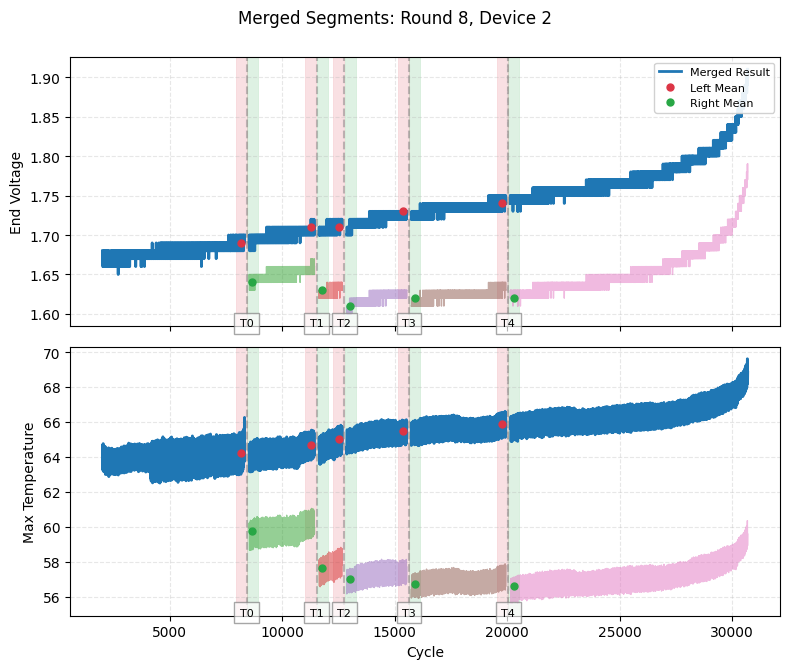

In [19]:
def plot_merged_segments(segmented_data, merged_data, devices, rounds, columns_to_clean):
    """
    Creates a publication-ready plot showing merged segments with transitions.
    """
    # Define professional color scheme
    merged_color = '#1f77b4'      # Dark blue for merged result
    segment_colors = [
        '#1f77b4',  # Steel blue
        '#2ca02c',  # Forest green
        '#d62728',  # Brick red
        '#9467bd',  # Purple
        '#8c564b',  # Brown
        '#e377c2',  # Pink
        '#7f7f7f',  # Gray
        '#bcbd22',  # Olive
        '#17becf',  # Cyan
        '#ff7f0e',  # Orange
    ]
    mean_colors = {'left': '#dc3545', 'right': '#28a745'}  # Red and green for transitions
    
    for round_number in rounds:
        for device in devices:
            if round_number not in segmented_data or device not in segmented_data[round_number]:
                print(f"Warning: No data for Round {round_number}, Device {device}. Skipping.")
                continue
            
            segments = segmented_data[round_number][device]
            if device not in merged_data[round_number]:
                print(f"Warning: No merged data for Round {round_number}, Device {device}. Skipping.")
                continue
            
            merged_segment, transition_means, mean_interval, transition_margin = merged_data[round_number][device]
            
            # Create figure
            fig, axes = plt.subplots(len(columns_to_clean), 1, figsize=(8, 3.5 * len(columns_to_clean)), 
                                   sharex=True)
            if len(columns_to_clean) == 1:
                axes = [axes]
            
            # Loop through columns
            for col_idx, column in enumerate(columns_to_clean):
                ax = axes[col_idx]
                
                # Plot segments with medium opacity and thicker lines
                for i, segment in enumerate(segments):
                    if column in segment.columns:
                        ax.plot(segment['cycle'], segment[column], 
                               color=segment_colors[i % len(segment_colors)], 
                               linestyle='-', alpha=0.5, linewidth=1,
                               label=f'Segment {i}')

                # Plot merged data on top
                if column in merged_segment.columns:
                    ax.plot(merged_segment['cycle'], merged_segment[column], 
                           color=merged_color, linewidth=2, label='Merged Result')

                # Sort and plot transitions
                column_transitions = [
                    (transition_cycle, col_name, first_mean, second_mean)
                    for transition_cycle, col_name, first_mean, second_mean in transition_means
                    if col_name == column
                ]
                column_transitions.sort(key=lambda x: x[0])
                
                # Plot transitions
                for i, (transition_cycle, _, first_mean, second_mean) in enumerate(column_transitions):
                    # Plot means as markers
                    ax.plot(transition_cycle - mean_interval/2, first_mean, 'o', 
                           color=mean_colors['left'], markersize=5)
                    ax.plot(transition_cycle + mean_interval/2, second_mean, 'o', 
                           color=mean_colors['right'], markersize=5)
                    
                    # Add transition regions with black boundaries
                    ax.axvspan(transition_cycle - mean_interval, transition_cycle - transition_margin, 
                             color=mean_colors['left'], alpha=0.15, 
                             edgecolor='black', linewidth=0.5)
                    ax.axvspan(transition_cycle + transition_margin, transition_cycle + mean_interval, 
                             color=mean_colors['right'], alpha=0.15,
                             edgecolor='black', linewidth=0.5)
                    
                    # Add transition markers
                    ax.axvline(x=transition_cycle, color='gray', linestyle='--', alpha=0.5)
                    ax.text(transition_cycle, ax.get_ylim()[0], f'T{i}', 
                           bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7),
                           horizontalalignment='center', fontsize=8)
                
                # Customize appearance
                ax.grid(True, linestyle='--', alpha=0.3)
                ax.set_ylabel(column.replace('_', ' ').title(), fontsize=10)
                if col_idx == len(columns_to_clean) - 1:
                    ax.set_xlabel('Cycle', fontsize=10)
                
                # Add legend
                if col_idx == 0:
                    handles = [plt.Line2D([0], [0], color=merged_color, linewidth=2, label='Merged Result')]
                    handles.extend([
                        plt.Line2D([0], [0], color=mean_colors['left'], marker='o', linestyle='none', 
                                 markersize=5, label='Left Mean'),
                        plt.Line2D([0], [0], color=mean_colors['right'], marker='o', linestyle='none', 
                                 markersize=5, label='Right Mean')
                    ])
                    ax.legend(handles=handles, loc='upper right', fontsize=8, framealpha=0.9)
            
            plt.suptitle(f'Merged Segments: Round {round_number}, Device {device}', 
                        fontsize=12, y=0.95)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            
            return fig, axes

# Example usage
plot_merged_segments(
    segmented_data=filtered_data,
    merged_data=merged_data,
    devices=[2],
    rounds=[8],
    columns_to_clean=['end_voltage', 'max_temperature']
)

In [20]:
def fill_gaps(merged_data, columns_to_fill, window_size=1000):
    filled_data = {}
    total_nans_filled = 0
    total_values = 0
    gap_sizes = []  # Store the sizes of gaps filled

    for round_number, devices in merged_data.items():
        filled_data[round_number] = {}
        
        for device, device_data in devices.items():
            if device_data is None:
                filled_data[round_number][device] = None
                continue
                
            merged_segment, transition_means, mean_interval, transition_margin = device_data
            filled_segment = merged_segment.copy()
            
            for column in columns_to_fill:
                before_fill = filled_segment[column].isna().sum()

                # Calculate rolling mean using center=False to use only prior values
                rolling_mean = filled_segment[column].rolling(window=window_size, min_periods=1, center=False).mean()
                
                # Detect and measure gaps before filling
                gap_start = None
                for idx, is_nan in enumerate(filled_segment[column].isna()):
                    if is_nan and gap_start is None:
                        gap_start = idx  # Mark the start of a gap
                    elif not is_nan and gap_start is not None:
                        gap_sizes.append(idx - gap_start)  # Store the gap size
                        gap_start = None
                # Handle if a gap continues to the end
                if gap_start is not None:
                    gap_sizes.append(len(filled_segment) - gap_start)

                filled_segment[column] = filled_segment[column].fillna(rolling_mean)
                after_fill = filled_segment[column].isna().sum()
                total_nans_filled += (before_fill - after_fill)
                total_values += len(filled_segment[column])
            
            filled_data[round_number][device] = (filled_segment, transition_means, mean_interval, transition_margin)

    # Calculate statistics for gaps
    if gap_sizes:
        max_gap = max(gap_sizes)
        min_gap = min(gap_sizes)
        mean_gap = sum(gap_sizes) / len(gap_sizes)
        std_gap = (sum((x - mean_gap) ** 2 for x in gap_sizes) / len(gap_sizes)) ** 0.5
    else:
        max_gap, min_gap, mean_gap, std_gap = 0, 0, 0, 0

    total_gaps = len(gap_sizes)

    # Print statistics
    percentage_filled = (total_nans_filled / total_values * 100) if total_values > 0 else 0
    print(f"Total NaN values filled: {total_nans_filled:,} out of {total_values:,} values ({percentage_filled:.2f}%)")
    print(f"Gap Statistics: Max={max_gap}, Min={min_gap}, Mean={mean_gap:.2f}, Std={std_gap:.2f}, Total Gaps={total_gaps}")

    # Return the filled data and gap statistics
    return filled_data, {'max_gap': max_gap, 'min_gap': min_gap, 'mean_gap': mean_gap, 'std_gap': std_gap, 'total_gaps': total_gaps}


filled_merged_data, gap_statistics = fill_gaps(
   merged_data=merged_data,
   columns_to_fill=columns_to_clean,
    window_size= 1000
)


Total NaN values filled: 387,632 out of 15,794,160 values (2.45%)
Gap Statistics: Max=343, Min=102, Mean=212.52, Std=39.52, Total Gaps=1824


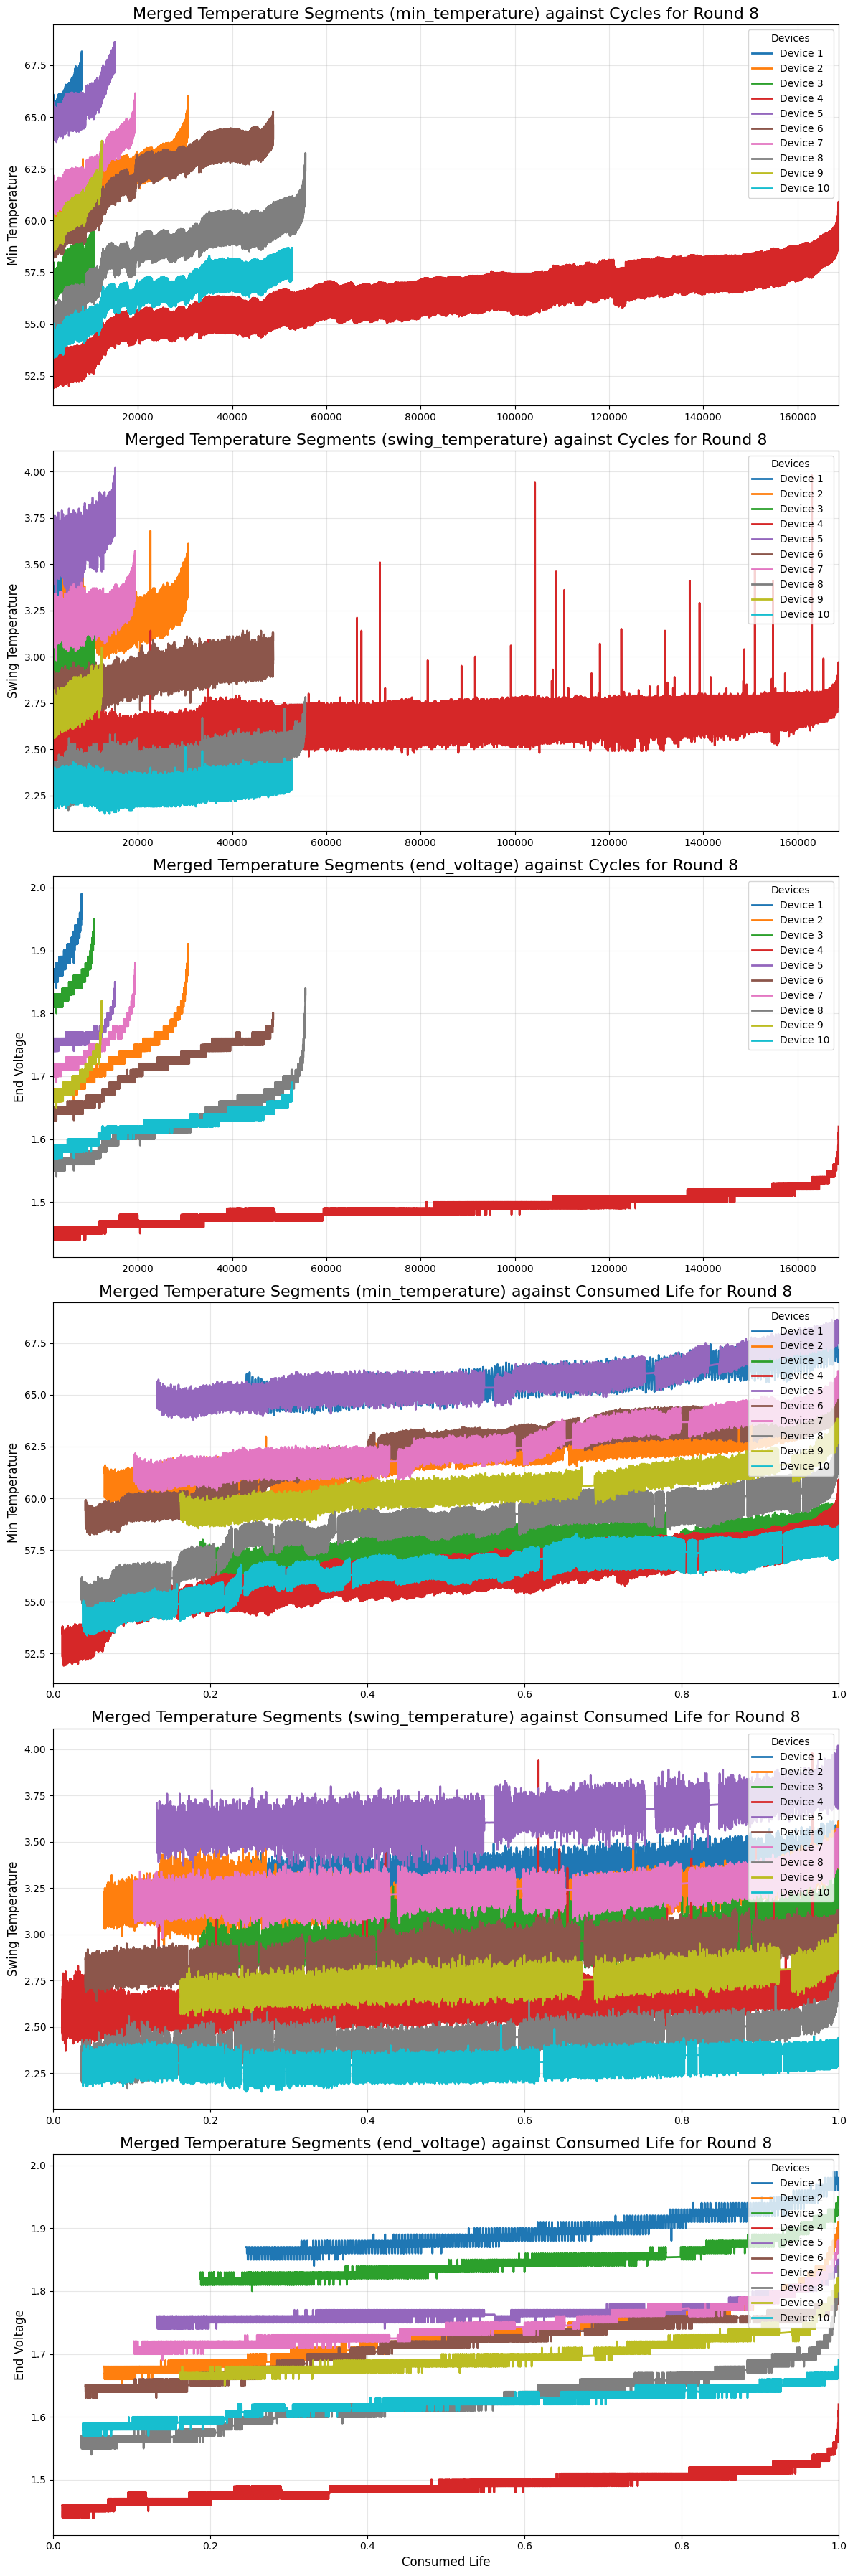

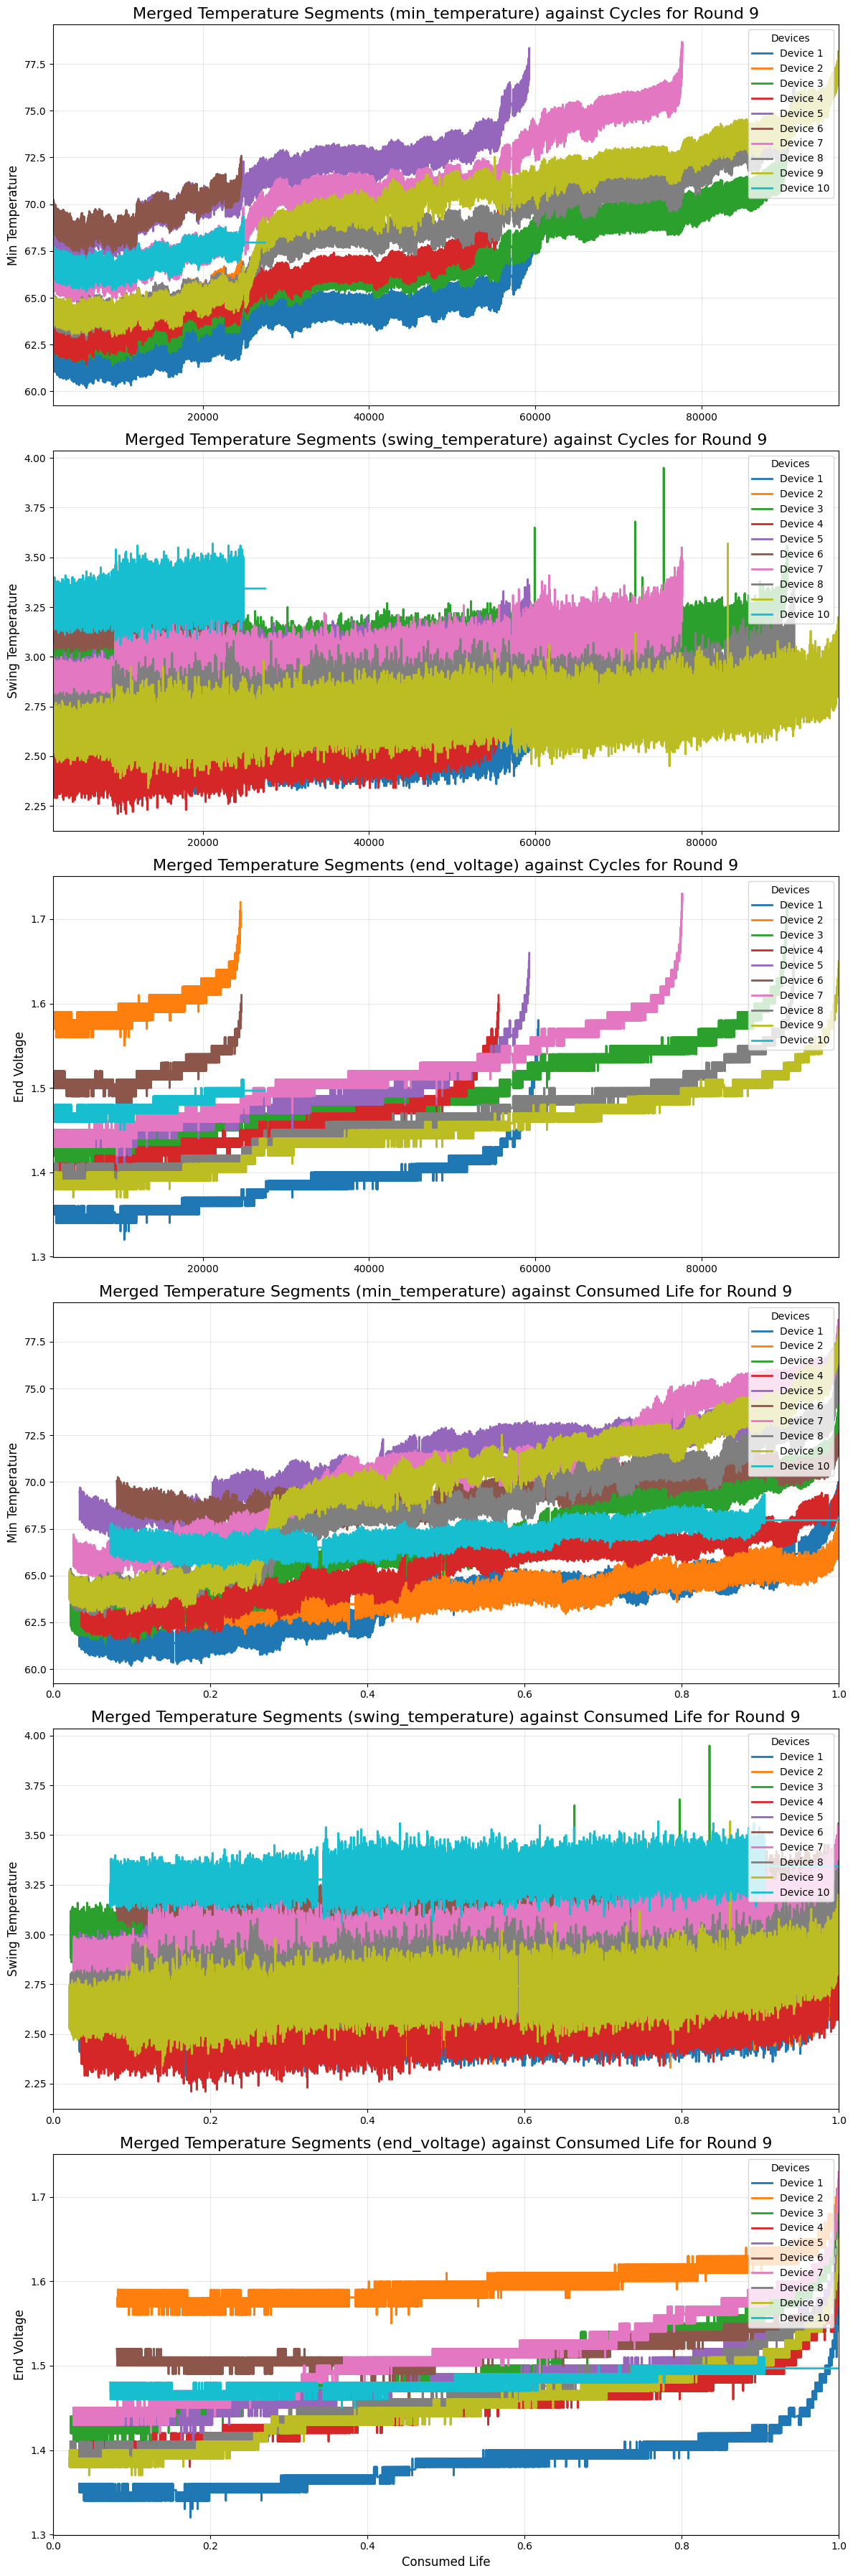

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_devices_merged(merged_data, devices, round_numbers):
    """
    Plots the merged segments for each device in separate figures for each round.
    Includes subplots for min_temperature, swing_temperature, and end_voltage 
    against both cycle and consumed_life.
    
    Args:
    - merged_data: Dictionary containing merged segment data for each round and device.
    - devices: List of devices to include in the plot.
    - round_numbers: List of round numbers to plot for all devices.
    """
    for round_number in round_numbers:
        fig, axs = plt.subplots(6, 1, figsize=(12, 36), sharex=False)  # 6 rows: 3 for cycles, 3 for consumed life
        colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))  # Unique colors for each device

        # Find min and max cycles across all devices for this round
        min_cycle = float('inf')
        max_cycle = float('-inf')
        for device in devices:
            if round_number in merged_data and device in merged_data[round_number]:
                merged_segment = merged_data[round_number][device][0]
                min_cycle = min(min_cycle, merged_segment['cycle'].min())
                max_cycle = max(max_cycle, merged_segment['cycle'].max())

        # Loop through each device and plot the data
        for i, device in enumerate(devices):
            if round_number not in merged_data or device not in merged_data[round_number]:
                print(f"Warning: No data for Round {round_number}, Device {device}. Skipping.")
                continue
            
            # Extract the merged segment for the specific device and round
            merged_segment = merged_data[round_number][device][0]  # merged_data contains [merged_segment, ...]

            # Plot against cycles
            axs[0].plot(
                merged_segment['cycle'], 
                merged_segment['min_temperature'], 
                label=f'Device {device}', 
                color=colors[i], 
                linewidth=2
            )
            axs[1].plot(
                merged_segment['cycle'], 
                merged_segment['swing_temperature'], 
                label=f'Device {device}', 
                color=colors[i], 
                linewidth=2
            )
            axs[2].plot(
                merged_segment['cycle'], 
                merged_segment['end_voltage'], 
                label=f'Device {device}', 
                color=colors[i], 
                linewidth=2
            )

            # Plot against consumed_life (assuming this exists in merged_segment)
            if 'consumed_life' in merged_segment:
                axs[3].plot(
                    merged_segment['consumed_life'], 
                    merged_segment['min_temperature'], 
                    label=f'Device {device}', 
                    color=colors[i], 
                    linewidth=2
                )
                axs[4].plot(
                    merged_segment['consumed_life'], 
                    merged_segment['swing_temperature'], 
                    label=f'Device {device}', 
                    color=colors[i], 
                    linewidth=2
                )
                axs[5].plot(
                    merged_segment['consumed_life'], 
                    merged_segment['end_voltage'], 
                    label=f'Device {device}', 
                    color=colors[i], 
                    linewidth=2
                )

        # Set titles and labels for each subplot
        axs[0].set_title(f'Merged Temperature Segments (min_temperature) against Cycles for Round {round_number}', fontsize=16)
        axs[0].set_ylabel('Min Temperature', fontsize=12)
        axs[0].grid(True, alpha=0.3)
        axs[0].set_xlim(min_cycle , max_cycle ) 

        axs[1].set_title(f'Merged Temperature Segments (swing_temperature) against Cycles for Round {round_number}', fontsize=16)
        axs[1].set_ylabel('Swing Temperature', fontsize=12)
        axs[1].grid(True, alpha=0.3)
        axs[1].set_xlim(min_cycle , max_cycle ) 

        axs[2].set_title(f'Merged Temperature Segments (end_voltage) against Cycles for Round {round_number}', fontsize=16)
        axs[2].set_ylabel('End Voltage', fontsize=12)
        axs[2].grid(True, alpha=0.3)
        axs[2].set_xlim(min_cycle , max_cycle ) 

        axs[3].set_title(f'Merged Temperature Segments (min_temperature) against Consumed Life for Round {round_number}', fontsize=16)
        axs[3].set_ylabel('Min Temperature', fontsize=12)
        axs[3].grid(True, alpha=0.3)
        axs[3].set_xlim(0, 1)  # Set x-axis limits explicitly for consumed_life plots

        axs[4].set_title(f'Merged Temperature Segments (swing_temperature) against Consumed Life for Round {round_number}', fontsize=16)
        axs[4].set_ylabel('Swing Temperature', fontsize=12)
        axs[4].grid(True, alpha=0.3)
        axs[4].set_xlim(0, 1)

        axs[5].set_title(f'Merged Temperature Segments (end_voltage) against Consumed Life for Round {round_number}', fontsize=16)
        axs[5].set_xlabel('Consumed Life', fontsize=12)
        axs[5].set_ylabel('End Voltage', fontsize=12)
        axs[5].grid(True, alpha=0.3)
        axs[5].set_xlim(0, 1)

     

        # Add legends to each subplot
        for ax in axs:
            ax.legend(loc='upper right', title="Devices")

        plt.tight_layout()
        plt.show()

# Define the list of rounds you want to plot
rounds_to_plot = [8, 9]

# Plot all devices' merged segments for the specified rounds
plot_all_devices_merged(
    merged_data=filled_merged_data,
    devices=devices,
    round_numbers=rounds_to_plot
)


In [22]:
def calculate_moving_averages(merged_data, window_size=25):
    """
    Calculate the moving average of all numeric columns (except 'round' and 'device') 
    for each round and device in merged_data.
    
    Parameters:
    - merged_data: dict, nested dictionary with structure {round_number: {device: [DataFrame]}}.
    - window_size: int, the window size for calculating the moving averages (default is 25).
    
    Returns:
    - result_data: dict, nested dictionary with structure {round_number: {device: DataFrame}}.
    """
    # Initialize an empty dictionary to store the results
    result_data = {}
    
    # Columns to exclude from moving average calculation
    exclude_columns = ['round', 'device', 'cycle', 'consumed_life']
    
    total_removed_rows = 0  # Counter for removed rows across all DataFrames
    total_original_rows = 0  # Counter for total rows before processing

    # Iterate over each round in merged_data
    for round_number, devices in merged_data.items():
        # Initialize a dictionary for each round
        result_data[round_number] = {}
        
        # Iterate over each device in the round
        for device, data_list in devices.items():
            # Clone the DataFrame to avoid modifying the original data
            df = data_list[0].copy()
            
            # Keep track of original row count
            original_row_count = len(df)
            total_original_rows += original_row_count
            
            # Get all numeric columns except excluded columns
            numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
            numeric_columns = [col for col in numeric_columns if col not in exclude_columns]
            
            # Calculate the moving average for all selected numeric columns
            for column in numeric_columns:
                df[column] = df[column].rolling(window=window_size).mean()
            
            # Drop rows where any column contains NaN values
            df.dropna(inplace=True)
            
            # Count removed rows for this DataFrame
            removed_rows = original_row_count - len(df)
            total_removed_rows += removed_rows
            
            # Store the DataFrame directly in the result_data dictionary (not in a list)
            result_data[round_number][device] = df
    
    # Total rows removed summary
    print(f"Total rows removed: {total_removed_rows} out of {total_original_rows} "
          f"({100 * total_removed_rows / total_original_rows:.2f}%)")
    
    # Expected rows removed due to rolling window
    num_devices = sum(len(devices) for devices in merged_data.values())
    expected_rows_removed = (window_size - 1) * num_devices
    print(f"Expected rows removed due to window size ({window_size}): {expected_rows_removed}")
    
    return result_data

# Example usage:
window_size = 250  
m_average_data = calculate_moving_averages(filled_merged_data, window_size)

# Print number of rows removed from start and end (window_size - 1 at each end for each device)
print(f"Expected rows removed  {((window_size -1 )*10*2)}")

Total rows removed: 4980 out of 987135 (0.50%)
Expected rows removed due to window size (250): 4980
Expected rows removed  4980


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\2012922247.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 0.93])


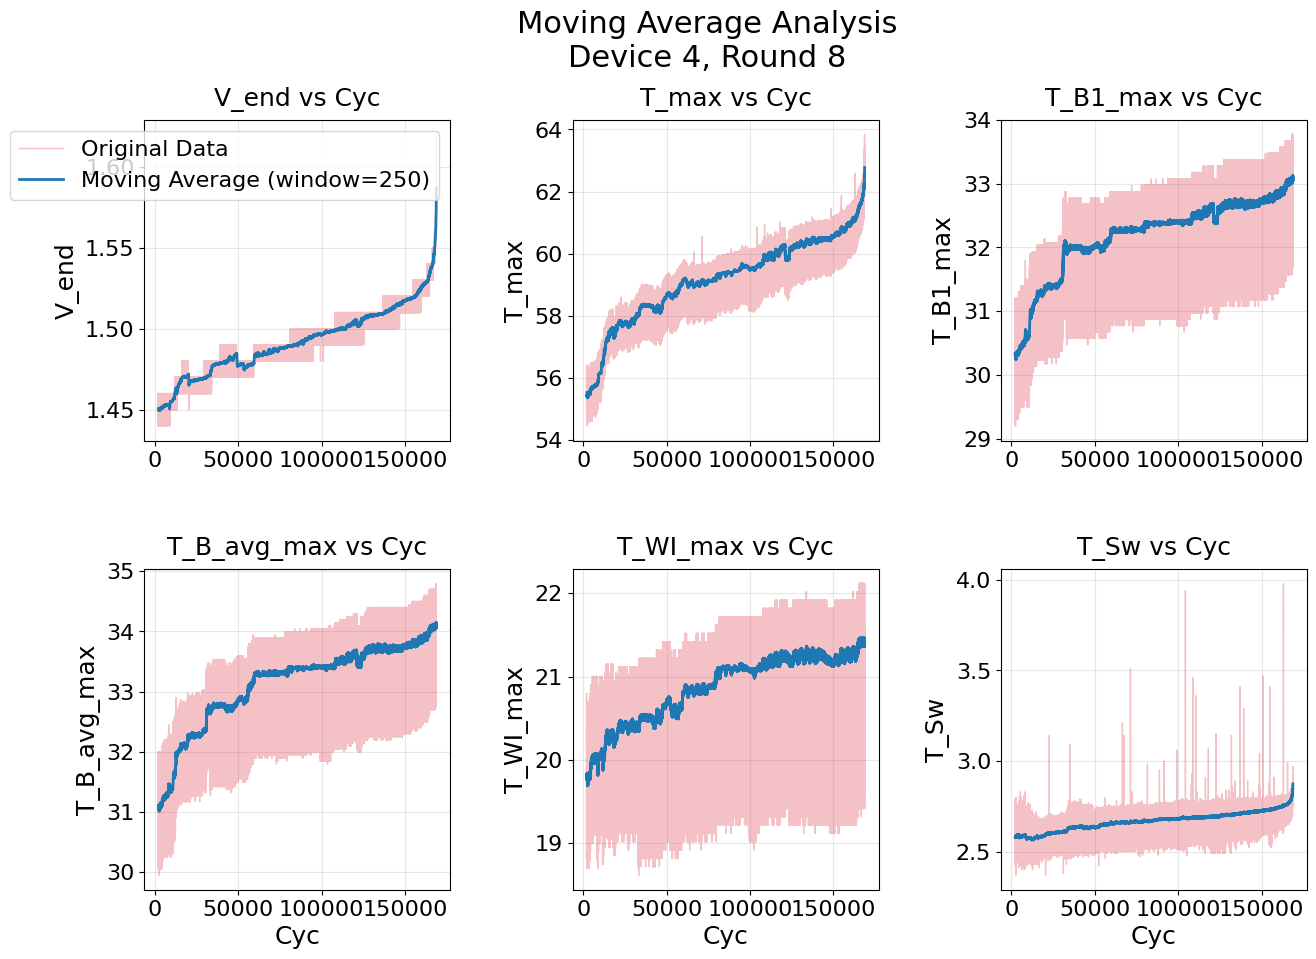

In [23]:
def plot_moving_averages(m_average_data, merged_data, devices, rounds, columns_to_clean, abbreviations, window_size):
    """
    Plots moving averages in a publication-ready 2x3 grid with the original merged data.
    """
    # Define colors
    original_color = '#dc3545'    # Bootstrap red for original data
    avg_color = '#1f77b4'        # Nice blue for moving average
    
    # Font sizes
    TITLE_SIZE = 22
    AXIS_LABEL_SIZE = 18
    TICK_SIZE = 16
    LEGEND_SIZE = 16
    SUBTITLE_SIZE = 18
    
    def get_abbreviation(column_name):
        return abbreviations.get(column_name, column_name)
    
    for device in sorted(devices):
        for round_number in sorted(rounds):
            if round_number not in m_average_data or device not in m_average_data[round_number]:
                print(f"No moving average data available for round {round_number}, device {device}. Skipping.")
                continue

            # Create 2x3 grid of subplots
            fig = plt.figure(figsize=(15, 10))
            gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.4)
            axes = []
            
            # Create subplots
            for i in range(2):
                for j in range(3):
                    if i*3 + j < len(columns_to_clean):
                        ax = fig.add_subplot(gs[i, j])
                        axes.append(ax)

            # Plot data
            for idx, column in enumerate(columns_to_clean):
                ax = axes[idx]
                
                # Plot original merged data
                merged_segment = merged_data[round_number][device][0]  # First element is merged segment
                if column in merged_segment.columns:
                    ax.plot(merged_segment['cycle'], merged_segment[column], 
                           color=original_color, alpha=0.3, linewidth=1,
                           label='Original Data')

                # Plot moving average with updated data structure
                ma_df = m_average_data[round_number][device]  # Now directly a DataFrame
                if column in ma_df.columns:
                    ax.plot(ma_df['cycle'], ma_df[column], 
                           color=avg_color, alpha=1.0, linewidth=2,
                           label=f'Moving Average (window={window_size})')

                # Customize plot appearance
                abbreviated_name = get_abbreviation(column)
                ax.set_ylabel(abbreviated_name, fontsize=AXIS_LABEL_SIZE)
                ax.set_xlabel(get_abbreviation('cycle') if idx >= 3 else '', 
                            fontsize=AXIS_LABEL_SIZE)
                ax.set_title(f'{abbreviated_name} vs {get_abbreviation("cycle")}', 
                           fontsize=SUBTITLE_SIZE, pad=10)
                ax.grid(True, alpha=0.3)
                
                # Tick parameters
                ax.tick_params(axis='both', labelsize=TICK_SIZE)
                
                # Add legend to first subplot only
                if idx == 0:
                    ax.legend(fontsize=LEGEND_SIZE, loc='upper right')

            # Add main title
            fig.suptitle(f'Moving Average Analysis\nDevice {device}, Round {round_number}', 
                        fontsize=TITLE_SIZE, y=0.99)

            # Adjust layout
            plt.tight_layout(rect=[0, 0.02, 1, 0.93])
            
            return fig, axes

# Example usage
fig, axes = plot_moving_averages(
    m_average_data=m_average_data,
    merged_data=merged_data,
    devices=[4],
    rounds=[8],
    columns_to_clean=['end_voltage', 'max_temperature', 'max_block_temperature_1', 
                     'avg_max_block_temperature', 'max_water_inlet_temperature', 
                     'swing_temperature'],
    abbreviations=abbreviations,
    window_size=window_size
)

plt.show()

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\4206257230.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


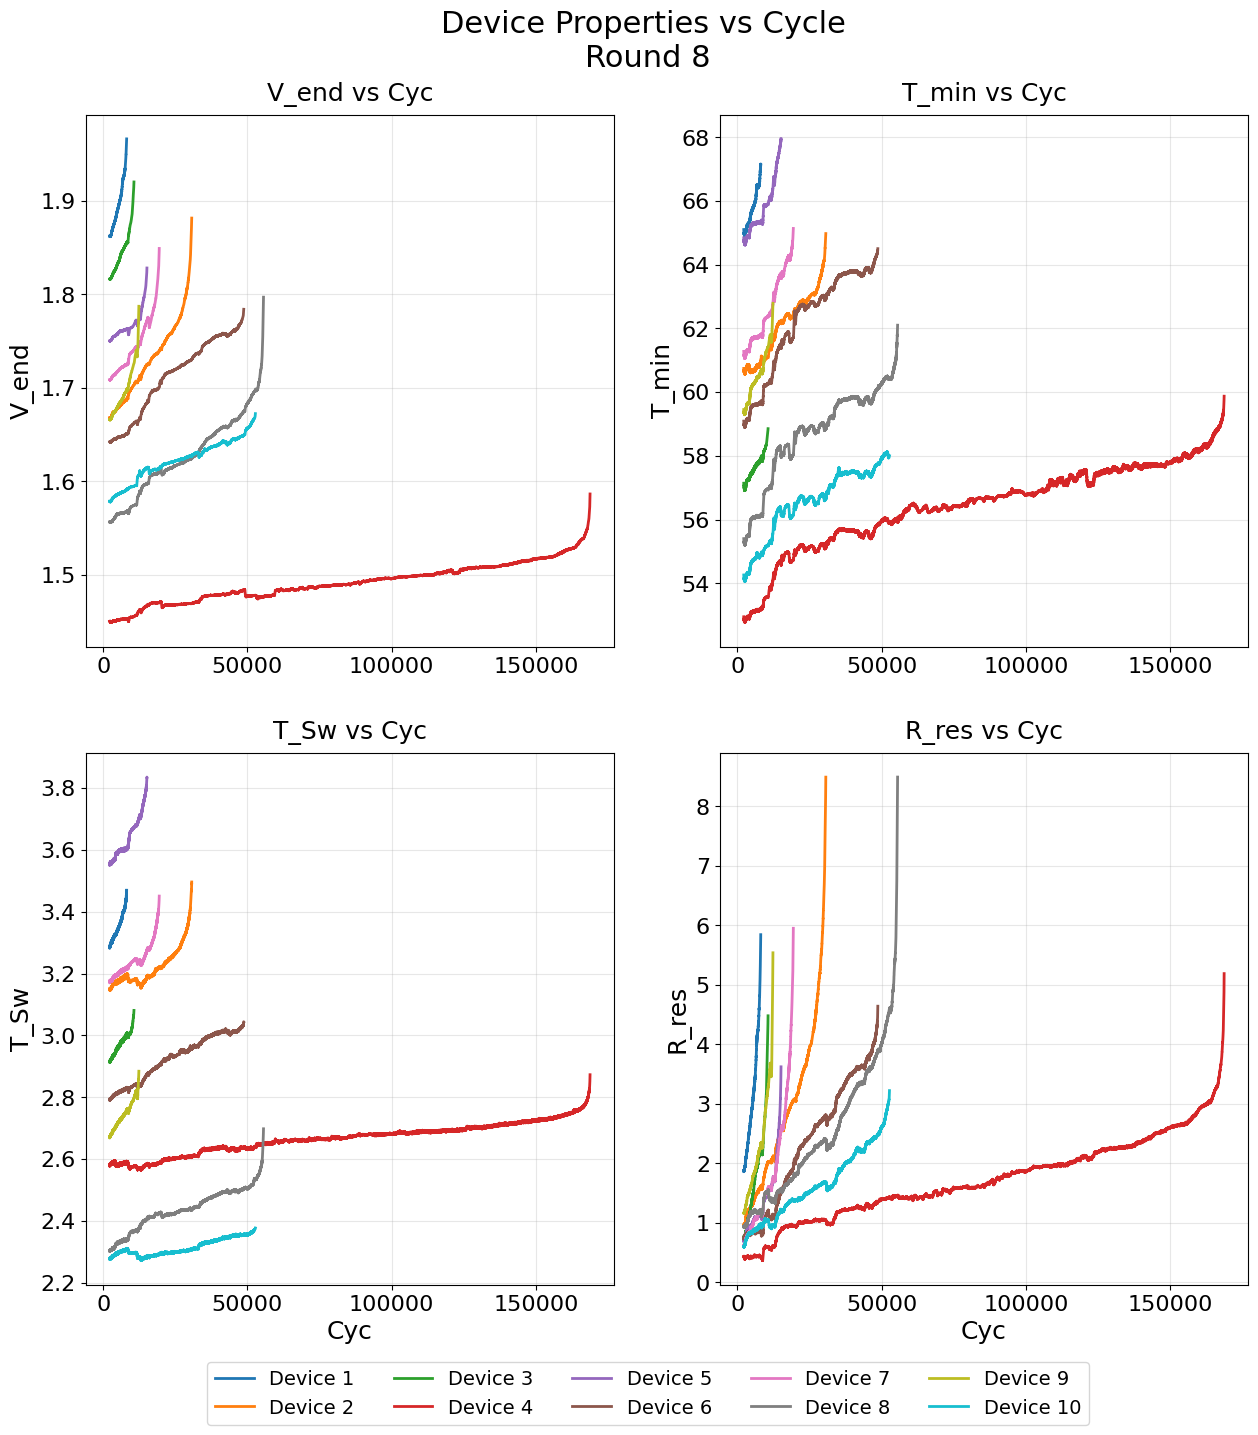

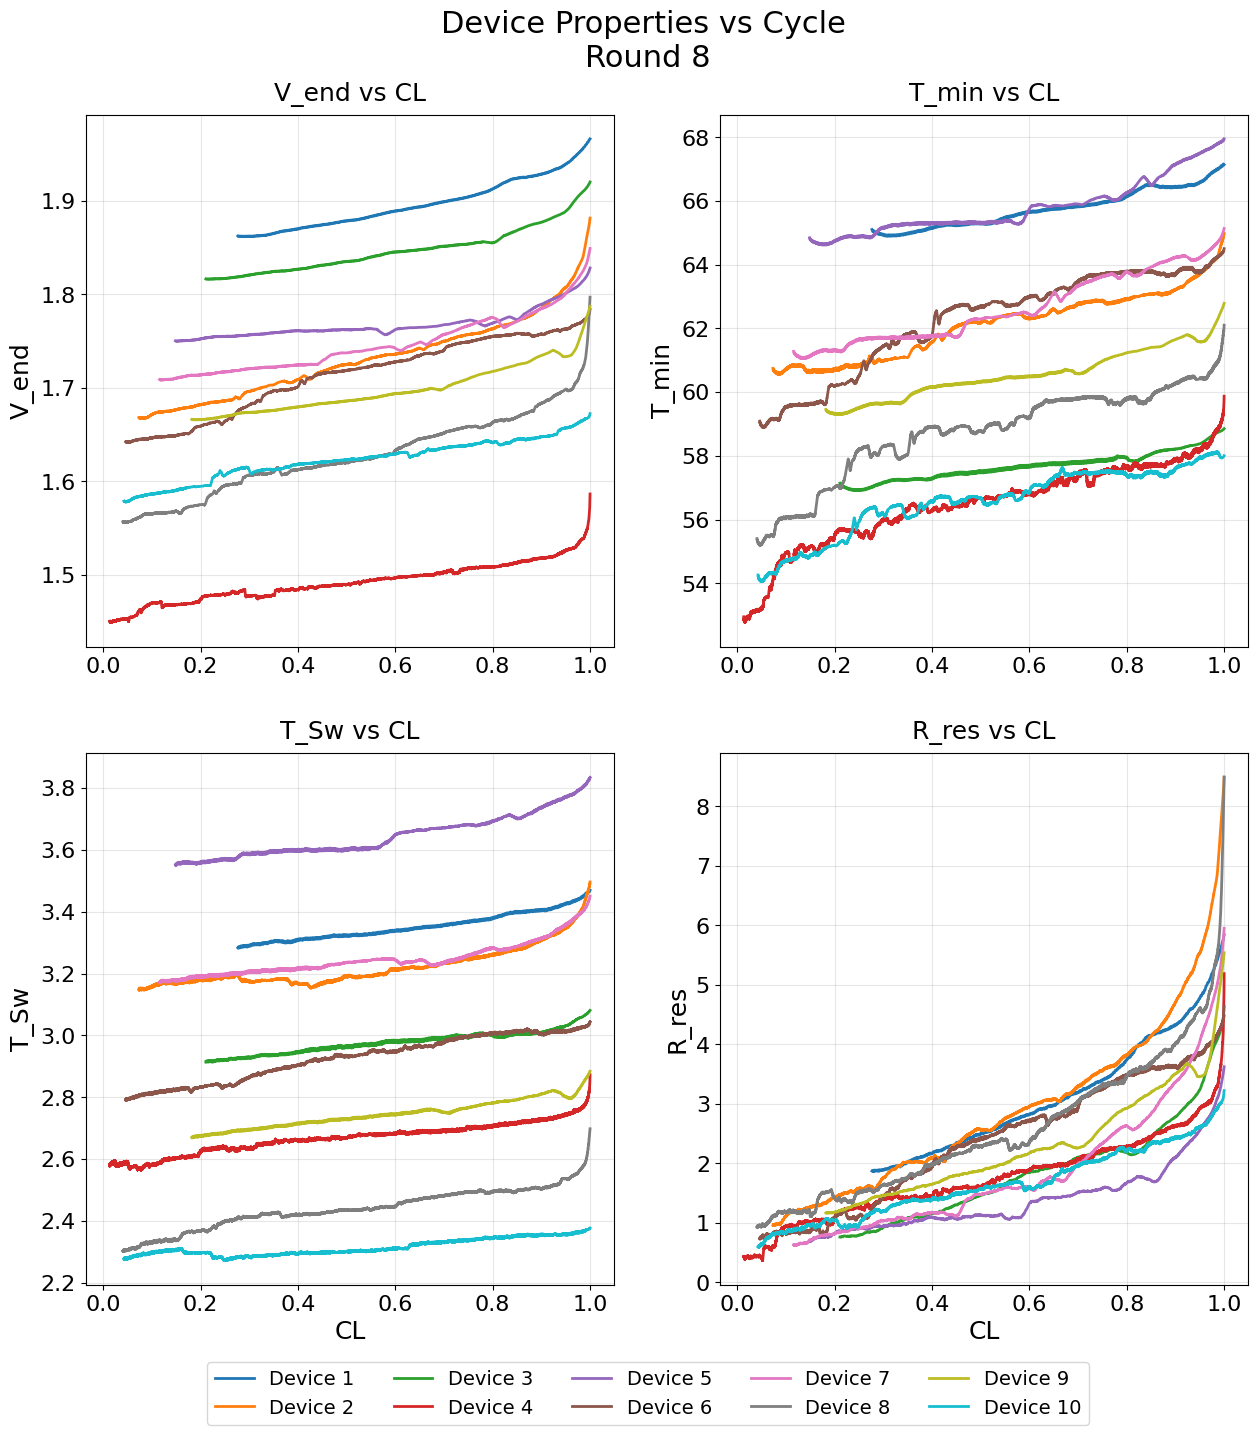

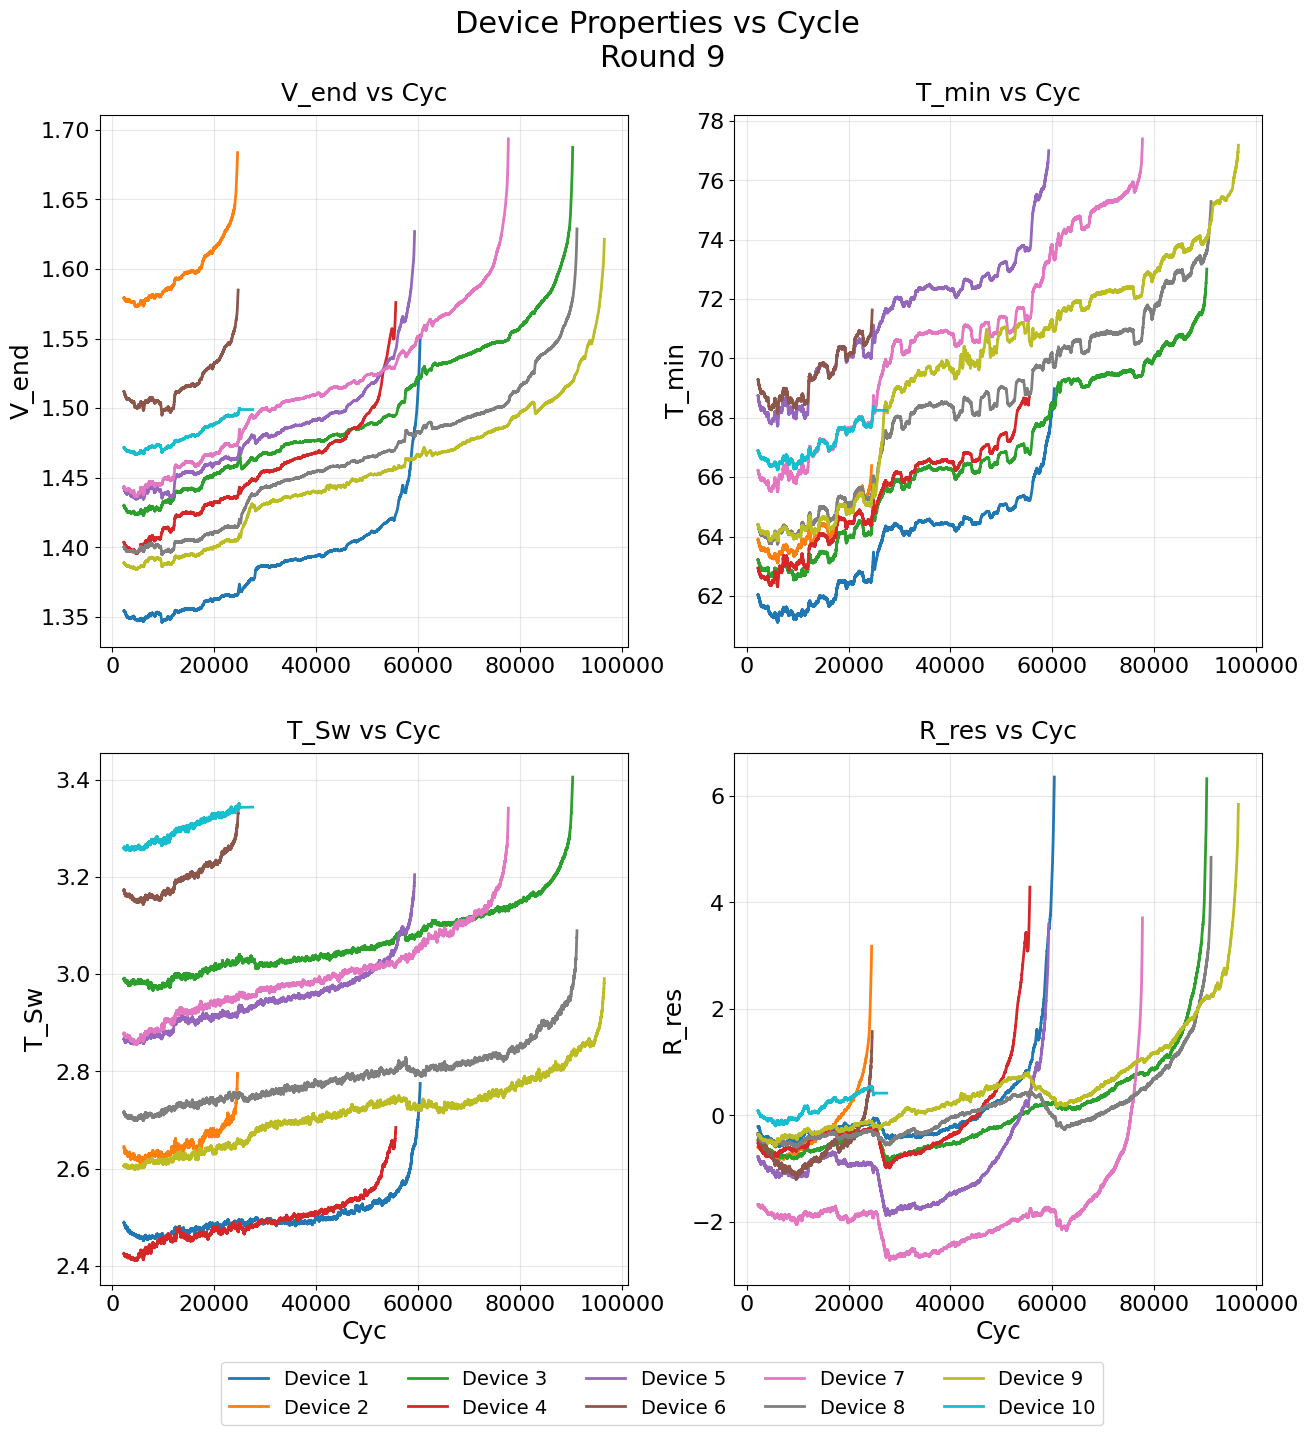

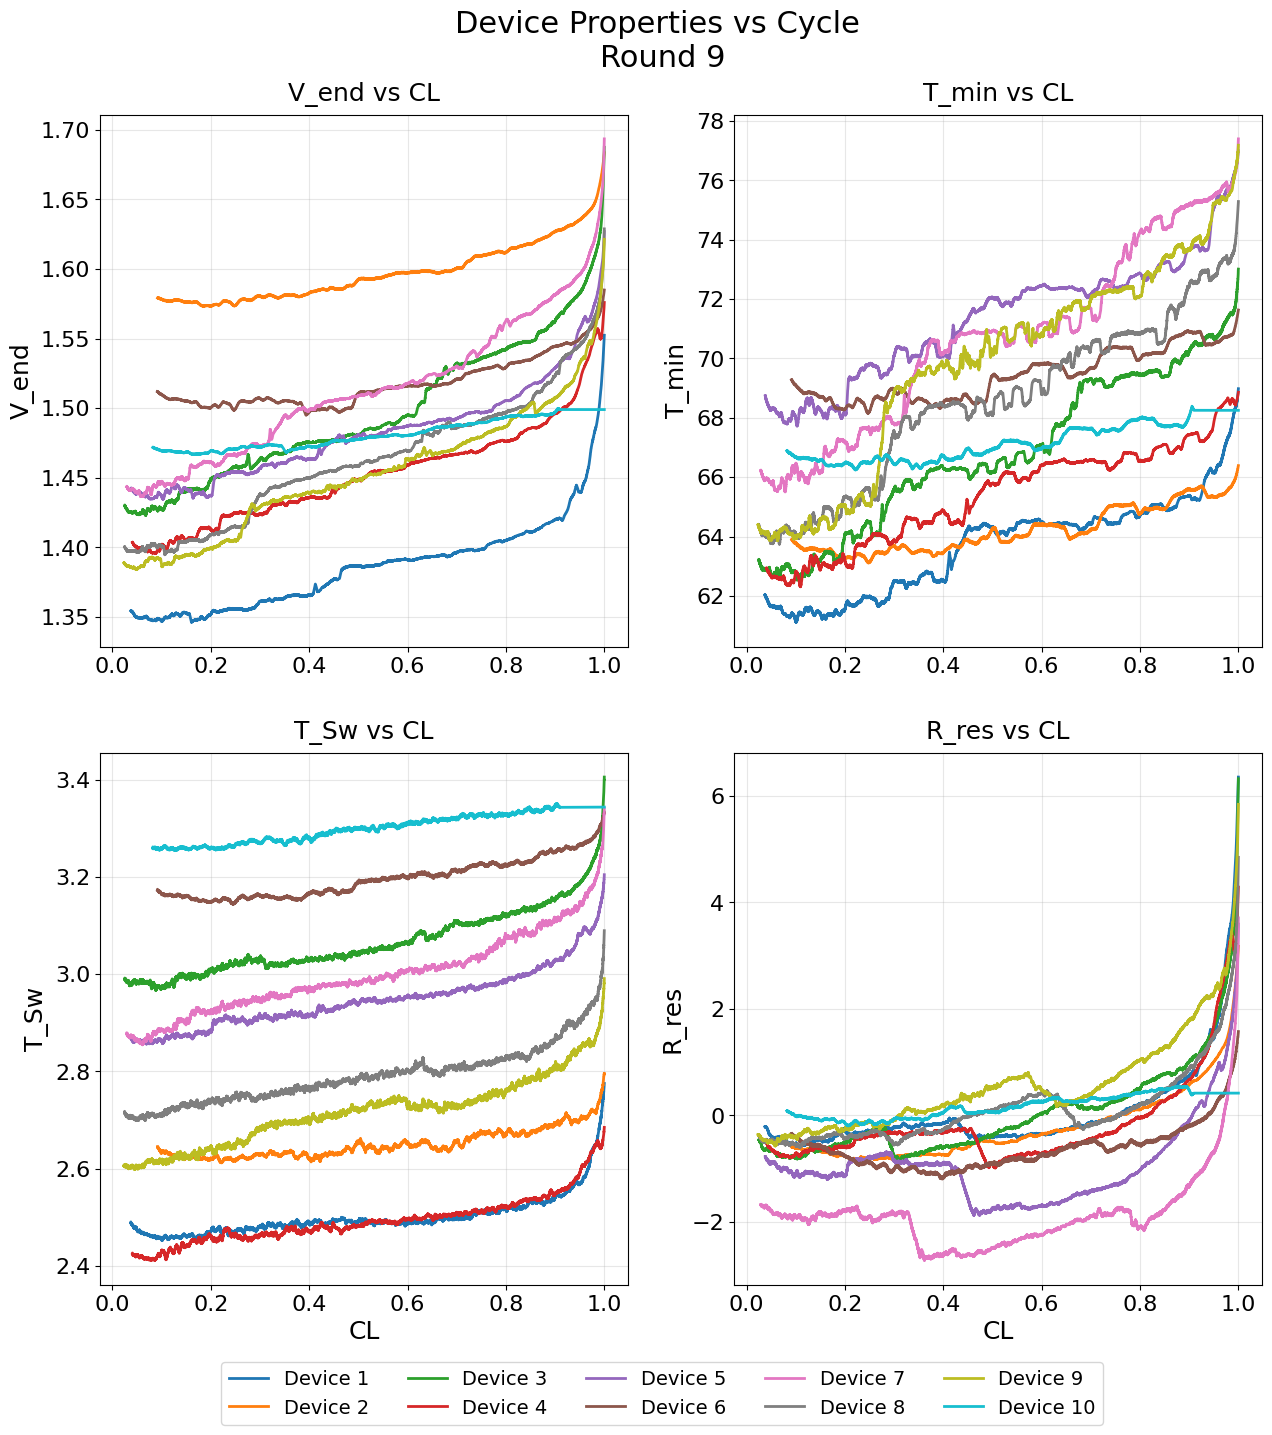

In [24]:
def plot_device_comparison(m_average_data, devices, round_number, abbreviations, window_size, x_axis='cycle'):
    """
    Plots moving averages for all devices in one round in a 2x2 grid with improved legend.
    Each subplot shows the comparison between devices for specific measurements.
    """
    # Define specific columns to plot
    columns_to_plot = ['end_voltage', 'min_temperature', 
                      'swing_temperature', 'end_resistance_residual']
    
    # Define color palette for different devices
    colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))
    
    # Font sizes
    TITLE_SIZE = 22
    AXIS_LABEL_SIZE = 18
    TICK_SIZE = 16
    LEGEND_SIZE = 14
    SUBTITLE_SIZE = 18
    
    def get_abbreviation(column_name):
        return abbreviations.get(column_name, column_name)
    
    # Create figure
    fig = plt.figure(figsize=(15, 15))
    
    # Create gridspec
    gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
    axes = []
    
    # Create main subplots (2x2 grid)
    for i in range(2):
        for j in range(2):
            ax = fig.add_subplot(gs[i, j])
            axes.append(ax)
    
    # Plot data for each column
    lines = []
    labels = []
    
    for idx, column in enumerate(columns_to_plot):
        ax = axes[idx]
        
        # Plot each device's moving average
        for device_idx, device in enumerate(sorted(devices)):
            if round_number in m_average_data and device in m_average_data[round_number]:
                ma_df = m_average_data[round_number][device]
                if column in ma_df.columns and x_axis in ma_df.columns:
                    line = ax.plot(ma_df[x_axis], ma_df[column],
                                 color=colors[device_idx], alpha=1.0, linewidth=2)[0]
                    
                    if idx == 0:
                        lines.append(line)
                        labels.append(f'Device {device}')
        
        # Customize plot appearance
        abbreviated_name = get_abbreviation(column)
        ax.set_ylabel(abbreviated_name, fontsize=AXIS_LABEL_SIZE)
        ax.set_xlabel(get_abbreviation(x_axis) if idx >= 2 else '',
                     fontsize=AXIS_LABEL_SIZE)
        ax.set_title(f'{abbreviated_name} vs {get_abbreviation(x_axis)}',
                    fontsize=SUBTITLE_SIZE, pad=10)
        ax.grid(True, alpha=0.3)
        
        # Tick parameters
        ax.tick_params(axis='both', labelsize=TICK_SIZE)
    
    # Add legend at the bottom
    fig.legend(lines, labels,
              fontsize=LEGEND_SIZE,
              loc='lower center',
              bbox_to_anchor=(0.5, 0.00),
              ncol=5)
    
    # Add main title
    fig.suptitle(f'Device Properties vs Cycle \nRound {round_number}',
                 fontsize=TITLE_SIZE, y=0.95)
    
    # Adjust layout with space for legend at bottom
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make space for legend
    
    return fig, axes

# Example usage
fig, axes = plot_device_comparison(
    m_average_data=m_average_data,
    devices=list(range(1,11)),
    round_number=8,
    abbreviations=abbreviations,
    window_size=window_size,
    x_axis='cycle'
)

# Example usage
fig, axes = plot_device_comparison(
    m_average_data=m_average_data,
    devices=list(range(1,11)),
    round_number=8,
    abbreviations=abbreviations,
    window_size=window_size,
    x_axis='consumed_life'
)

# Example usage
fig, axes = plot_device_comparison(
    m_average_data=m_average_data,
    devices=list(range(1,11)),
    round_number=9,
    abbreviations=abbreviations,
    window_size=window_size,
    x_axis='cycle'
)

# Example usage
fig, axes = plot_device_comparison(
    m_average_data=m_average_data,
    devices=list(range(1,11)),
    round_number=9,
    abbreviations=abbreviations,
    window_size=window_size,
    x_axis='consumed_life'
)



C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\4141825598.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


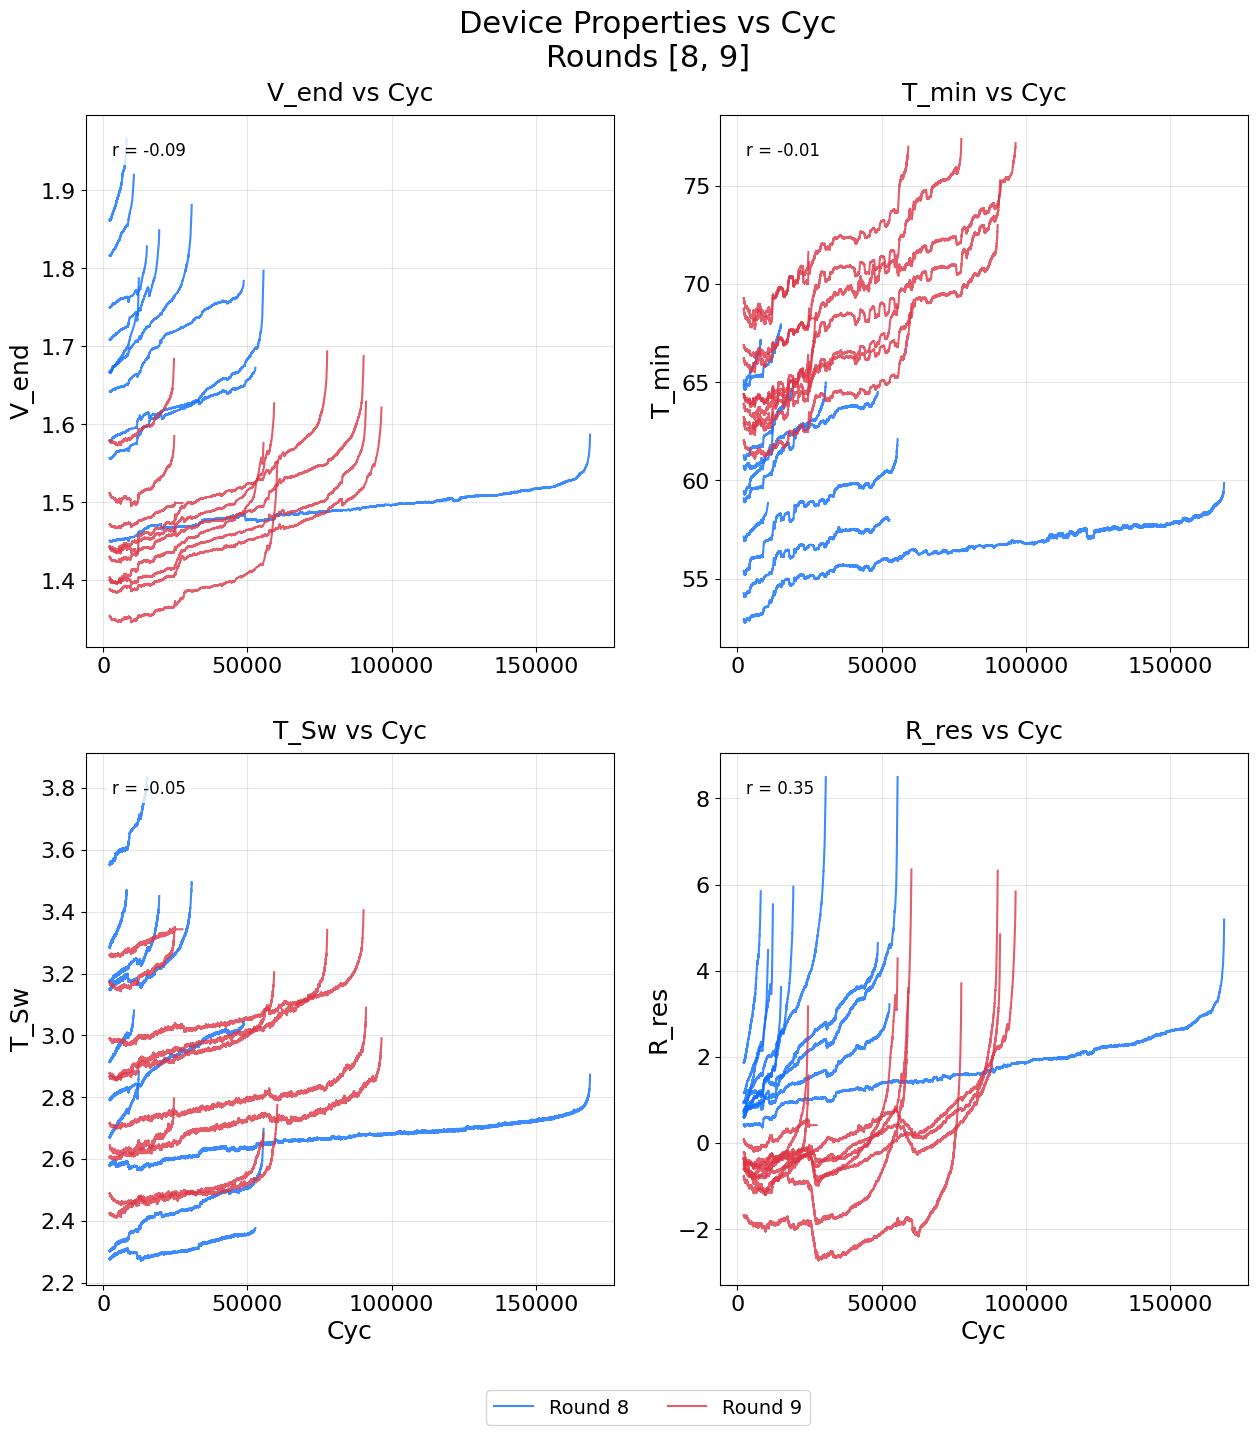

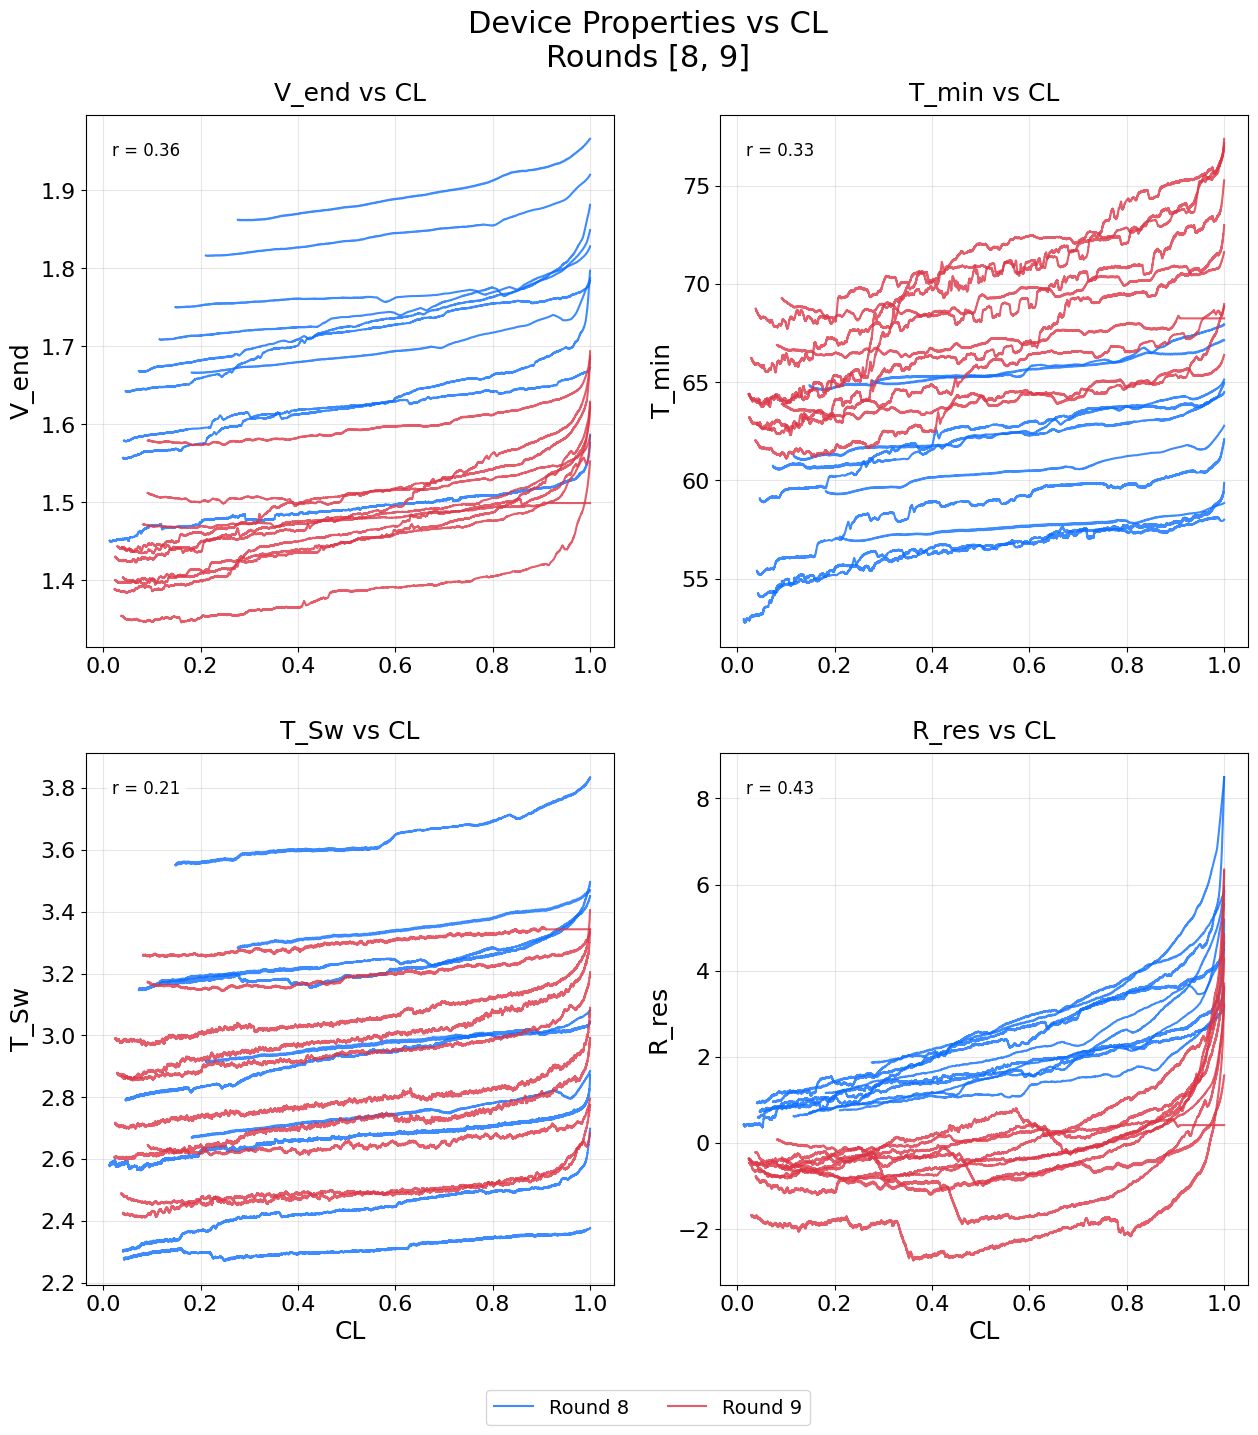

In [25]:
def plot_device_comparison_rounds(m_average_data, devices, rounds, abbreviations, x_axis='cycle'):
    """
    Plots moving averages for all devices in multiple rounds in a 2x2 grid.
    Each subplot shows the comparison between devices with correlation coefficients.
    """
    import numpy as np
    from scipy import stats
    
    # Define specific columns to plot
    columns_to_plot = ['end_voltage', 'min_temperature',
                      'swing_temperature', 'end_resistance_residual']
    
    # Define colors for rounds
    round_colors = {
        8: '#0d6efd',  # Nice blue
        9: '#dc3545'   # Bootstrap red
    }
    
    # Font sizes
    TITLE_SIZE = 22
    AXIS_LABEL_SIZE = 18
    TICK_SIZE = 16
    LEGEND_SIZE = 14
    SUBTITLE_SIZE = 18
    CORRELATION_SIZE = 12
    
    def get_abbreviation(column_name):
        return abbreviations.get(column_name, column_name)
    
    # Create figure
    fig = plt.figure(figsize=(15, 15))
    
    # Create gridspec
    gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
    axes = []
    
    # Create main subplots (2x2 grid)
    for i in range(2):
        for j in range(2):
            ax = fig.add_subplot(gs[i, j])
            axes.append(ax)
    
    # Plot data for each column
    lines = []
    labels = []
    
    # Pre-collect all data for correlation calculation
    all_data = {col: {x_axis: [], 'value': []} for col in columns_to_plot}
    
    for idx, column in enumerate(columns_to_plot):
        ax = axes[idx]
        
        # Plot each round
        for round_number in rounds:
            x_all = []
            y_all = []
            
            # Plot each device's moving average
            for device in sorted(devices):
                if round_number in m_average_data and device in m_average_data[round_number]:
                    ma_df = m_average_data[round_number][device]
                    if column in ma_df.columns and x_axis in ma_df.columns:
                        line = ax.plot(ma_df[x_axis], ma_df[column],
                                     color=round_colors[round_number],
                                     alpha=0.8, linewidth=1.5,
                                     label=f'Round {round_number}' if idx == 0 and device == devices[0] else "")
                        
                        # Collect data for correlation
                        x_all.extend(ma_df[x_axis].values)
                        y_all.extend(ma_df[column].values)
            
            # Store data for correlation
            all_data[column][x_axis].extend(x_all)
            all_data[column]['value'].extend(y_all)
        
        # Calculate and add correlation coefficient
        if len(all_data[column][x_axis]) > 0:
            r, _ = stats.pearsonr(all_data[column][x_axis], all_data[column]['value'])
            ax.text(0.05, 0.95, f'r = {r:.2f}',
                   transform=ax.transAxes,
                   fontsize=CORRELATION_SIZE,
                   verticalalignment='top',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        # Customize plot appearance
        abbreviated_name = get_abbreviation(column)
        ax.set_ylabel(abbreviated_name, fontsize=AXIS_LABEL_SIZE)
        ax.set_xlabel(get_abbreviation(x_axis) if idx >= 2 else '',
                     fontsize=AXIS_LABEL_SIZE)
        ax.set_title(f'{abbreviated_name} vs {get_abbreviation(x_axis)}',
                    fontsize=SUBTITLE_SIZE, pad=10)
        ax.grid(True, alpha=0.3)
        
        # Tick parameters
        ax.tick_params(axis='both', labelsize=TICK_SIZE)
    
    # Add legend
    fig.legend(fontsize=LEGEND_SIZE,
              loc='lower center',
              bbox_to_anchor=(0.5, 0.00),
              ncol=2)
    
    # Add main title
    fig.suptitle(f'Device Properties vs {get_abbreviation(x_axis)}\nRounds {rounds}',
                 fontsize=TITLE_SIZE, y=0.95)
    
    # Adjust layout with space for legend at bottom
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    return fig, axes

# Example usage for cycle plot
fig_cycle, axes_cycle = plot_device_comparison_rounds(
    m_average_data=m_average_data,
    devices=list(range(1,11)),
    rounds=[8, 9],
    abbreviations=abbreviations,
    x_axis='cycle'
)
fig_cycle.savefig('device_comparison_cycle.png', dpi=300, bbox_inches='tight')

# Example usage for consumed life plot
fig_life, axes_life = plot_device_comparison_rounds(
    m_average_data=m_average_data,
    devices=list(range(1,11)),
    rounds=[8, 9],
    abbreviations=abbreviations,
    x_axis='consumed_life'
)
fig_life.savefig('device_comparison_consumed_life.png', dpi=300, bbox_inches='tight')

plt.show()

plt.show()

In [ ]:
def plot_parameter_correlations_rounds_fast(m_average_data, devices, rounds, abbreviations):
    """
    Creates a publication-ready matrix of scatter plots comparing parameter correlations for multiple rounds.
    Shows only Pearson correlation coefficients.
    """
    import numpy as np
    from scipy import stats
    import pandas as pd
    
    # Define parameters to plot
    params = ['end_voltage', 'end_resistance_residual', 'min_temperature', 'swing_temperature']
    n_params = len(params)
    
    # Define colors for rounds - swapped colors
    round_colors = {
        8: '#0d6efd',  # Nice blue
        9: '#dc3545'   # Bootstrap red
    }
    
    # Font sizes
    TITLE_SIZE = 24
    AXIS_LABEL_SIZE = 16
    TICK_SIZE = 14
    LEGEND_SIZE = 12
    CORRELATION_SIZE = 12
    
    # Pre-process data for all rounds and devices
    round_data = {}
    for round_number in rounds:
        dfs = []
        for device in devices:
            if round_number in m_average_data and device in m_average_data[round_number]:
                df = m_average_data[round_number][device][params].copy()
                df['round'] = round_number
                dfs.append(df)
        if dfs:
            round_data[round_number] = pd.concat(dfs, ignore_index=True)
    
    # Create figure
    fig = plt.figure(figsize=(15, 15), dpi=300)
    gs = fig.add_gridspec(n_params, n_params, hspace=0.3, wspace=0.3)
    
    # Pre-calculate correlations
    all_data = pd.concat(round_data.values(), ignore_index=True)
    correlations = np.zeros((n_params, n_params))
    
    for i in range(n_params):
        for j in range(i+1, n_params):
            r, _ = stats.pearsonr(all_data[params[i]], all_data[params[j]])
            correlations[i, j] = correlations[j, i] = r
    
    # Create scatter plots
    for i in range(n_params):
        for j in range(n_params):
            ax = fig.add_subplot(gs[i, j])
            
            if i != j:
                # Plot each round
                for round_number, data in round_data.items():
                    ax.scatter(data[params[j]], data[params[i]],
                             color=round_colors[round_number], 
                             alpha=0.6, s=15,
                             label=f'Round {round_number}' if i == 0 and j == n_params-1 else "",
                             edgecolors='none')
                
                # Add correlation coefficient
                ax.text(0.05, 0.95, 
                       f'r = {correlations[i,j]:.2f}',
                       transform=ax.transAxes,
                       fontsize=CORRELATION_SIZE,
                       verticalalignment='top',
                       bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
            
            # Customize plot appearance
            if i == n_params-1:
                ax.set_xlabel(abbreviations.get(params[j], params[j]), fontsize=AXIS_LABEL_SIZE)
            else:
                ax.set_xticks([])
            
            if j == 0:
                ax.set_ylabel(abbreviations.get(params[i], params[i]), fontsize=AXIS_LABEL_SIZE)
            else:
                ax.set_yticks([])
            
            if i == j:
                ax.text(0.5, 0.5, abbreviations.get(params[i], params[i]),
                       horizontalalignment='center',
                       verticalalignment='center',
                       fontsize=AXIS_LABEL_SIZE,
                       transform=ax.transAxes)
                ax.set_xticks([])
                ax.set_yticks([])
            
            ax.tick_params(axis='both', labelsize=TICK_SIZE)
            ax.grid(True, alpha=0.2)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    # Add legend in top left
    fig.legend(fontsize=LEGEND_SIZE,
              loc='upper left',
              bbox_to_anchor=(0.02, 0.98),
              ncol=1,
              frameon=True,
              edgecolor='black',
              title='Rounds',
              title_fontsize=LEGEND_SIZE)
    
    # Add title
    fig.suptitle(f'Parameter Correlations - Rounds {rounds}',
                 fontsize=TITLE_SIZE, y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjusted to prevent overlap with legend
    
    return fig

# Example usage
fig = plot_parameter_correlations_rounds_fast(
    m_average_data=m_average_data,
    devices=list(range(1,11)),
    rounds=[8, 9],
    abbreviations=abbreviations
)
fig.savefig('Parameter_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_8972\3316148090.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


KeyboardInterrupt: 

In [116]:
def calculate_total_rows_in_moving_average_data(m_average_data, original_df):
    """
    Calculates the total number of rows across all DataFrames in the m_average_data dictionary
    and computes the number and percentage of deleted rows compared to the original DataFrame.
    
    Parameters:
    - m_average_data: dict, nested dictionary with structure {round_number: {device: DataFrame}}
    - original_df: DataFrame, the original unsegmented DataFrame for comparison
    
    Returns:
    - total_rows: int, the total number of rows in all DataFrames combined.
    """
    total_rows = 0
    
    # Sum rows from all DataFrames in the nested dictionary
    for round_number, devices in m_average_data.items():
        for device, df in devices.items():
            total_rows += len(df)
    
    # Calculate deleted rows and percentage
    df_filtered = original_df[original_df['round'].isin([8, 9])]
    deleted_rows = len(df_filtered) - total_rows
    deletion_percentage = 100 * deleted_rows / len(df_filtered )
    deleted_row_due_to_CL_cutt = len(df_filtered[df_filtered['consumed_life'] > 1])
    moving_average_loss = 4980
    

    print(f'Total rows in moving average data: {total_rows:,}')
    print(f'Original rows: {len(df_filtered):,}')
    print(f'Total Deleted rows: {deleted_rows:,} ({deletion_percentage:.2f}%)')
    print(f'Deleted rows due to Initation: {39980:,} ({100*39980/len(df_filtered):.2f}%)')
    print(f'Deleted rows due to CL < 1: {deleted_row_due_to_CL_cutt:,} ({100*deleted_row_due_to_CL_cutt/len(df_filtered):.2f}%)')
    print(f'Deleted rows due to moving average: {moving_average_loss} ({moving_average_loss*100/len(df_filtered):.2f}%)' )
    print(f'Lost rows due to Cleaning: {deleted_rows- deleted_row_due_to_CL_cutt - 39980 - moving_average_loss:,} ({100*(deleted_rows-deleted_row_due_to_CL_cutt -moving_average_loss -39980)/len(df_filtered):.2f}%)')
    return total_rows

# Example usage:
total_rows = calculate_total_rows_in_moving_average_data(m_average_data, df)

Total rows in moving average data: 983,075
Original rows: 1,055,440
Total Deleted rows: 72,365 (6.86%)
Deleted rows due to Initation: 39,980 (3.79%)
Deleted rows due to CL < 1: 27,405 (2.60%)
Deleted rows due to moving average: 4980 (0.47%)
Lost rows due to Cleaning: 0 (0.00%)
